# Has the expansion of Ultra Low Emission Zone in 2021 improved air quality in London? How to quantify the improvement?

# 1 Introduction

London, one of the world's leading metropolises, has been grappling with the challenges of air pollution and its adverse effects on public health and the environment. In response, some of the most stringent transportation policies on emission control were implemented here, among which the Ultra Low Emission Zone (ULEZ) gained attention across academia, government departments and the commercial world. ULEZ was initiated in 2019 and expanded in 25th October, 2021, and expects a second expansion in August 2023.

![ulez-londonwide-expansion-2023-long-dwell-map-v20](https://www.dropbox.com/s/hx4m7geavmdofsr/ulez-londonwide-expansion-2023-long-dwell-map-v20.PNG?raw=1)

credit: https://lruc.content.tfl.gov.uk/ulez-londonwide-expansion-2023-long-dwell-map-v20.pdf

The primary goal of the ULEZ is to reduce toxic emission levels by imposing stricter emission standards for vehicles entering the designated zones. However, evaluating the causal impact of the ULEZ policy on air quality remains a crucial question.


A growing body of literature has explored the effects of low emission zones and transportation policies on air quality and public health. For instance, Beevers et al. (2016) found that London's Low Emission Zone (LEZ) policy had led to a reduction in nitrogen dioxide (NO2) and particulate matter (PM) emissions, by utilising air pollution dispersion models, which can be sensitive to input parameters and may not always account for all confounding factors, leaving room for alternative approaches to assess the policy's impact.

Similarly, Tonne et al. (2018) reported improvements in air quality and potential health benefits following the implementation of London's LEZ, with primary focus on socioeconomic and ethnic inequalities in exposure to air and noise pollution, leaving the causal relationship between the policy and air quality improvements uninvestigated .

As for studies doing causal inference on policies on air regulation, Ma et al.(2021) introduces a “donut hole” when coping with transient time the ULEZ initiation in 2019 needed to take effect. Despite the study’s good capture of the lagged effect of the policy and the quantification of the effect for each site, which led to a more robust RDD, the problems of spatial patterns exhibited by the improvements and a better presentation of air pollutants are left open.

RDD offers a quasi-experimental approach, enabling us to estimate the causal effect of the ULEZ expansion on air quality by exploiting the discontinuity created by the policy's implementation date. This method allows for robust analysis while accounting for potential confounding factors and biases.

In this study, we will analyse air quality data collected from monitoring stations across London, focusing on key air pollutants, to investigate the causal relationship between the ULEZ expansion in 25th October 2021 (the current boundary, indicated by the green boundary, covering up to (but not including) the North and South Circular Roads) and improvements in air quality. The findings of this research will not only contribute to the understanding of the ULEZ policy's effectiveness but also inform future policy decisions and urban planning efforts to mitigate air pollution and enhance public health.

<!-- The current ULEZ .
![ulez_october_2021](https://assets.londonist.com/uploads/2021/10/i875/ulez_october_2021.jpg)

credit: https://assets.londonist.com/ -->


# 2 Research Question

* Question 1: Has the expansion of ULEZ(Ultra Low Emission Zone) in October 2021 improved air quality in London?
* Question 2: How to quantify the improvement?  
To solve these two questions, this notebook has tackled the following subquestions which are keystones of the analysis process:
 * How to categorise air pollutants into one or more synthesised indicator(s) of air quality?
 * How to confirm there is causal relationship between the expansion and the improvement?
 * What spatial patterns have been shown in the air quality imrpovements?

# 3 Methodology




Data Preprocessing: 
a. In order to deal with missing values in the dataset, Linear interpolation and KNN(K-Nearest Neighbours) imputation are tested to fill in the gaps for each site.
b. To take into consideration of seasonality, trend and periodicity in imputation, SARISMA was adopted. However, these can also act as confounders in RDD design, which might require differencing, decomposition and seasonal adjustment.   

Dimensionality Reduction: To derive one air indicator based on air pollutants features, DR(Dimension Reduction) methods have been tested. PCA (Principal Component Analysis) is good at preserving variance and visualising the preservation, but falls behind when my data contains complex non-linear information. Therefore KPCA(Kernel PCA), t-SNE(t-Distributed Stochastic Neighbor Embedding) and UMAP (Uniform Manifold Approximation and Projection) are tested to cope with non-linearity at the price of reduced interpretability. However, t-SNE proved a validation of site type categorisation.  

Analysis:
For causal inference, I adopted RDD(Regression Discontinuity Design) on time which assumes that a forcing variable (here "post_expansion") can apply treatment on both sides of the threshold, i.e., 25th October, 2021, the date of expansion implementation. 
DID (Difference-in-differences) does not apply to this research as the expanded boundary can't serve as the distinction between a treatment group and a control group.


In [1]:
# First let's check the moduels that are likely to be not installed in most environments
# List of modules to check if installed
# List of modules to check and install if not already installed
to_check_install = [
    'bioinfokit',  # for PCA biplot
    'gwr',         # A library for Geographically Weighted Regression (GWR) analysis
    'pysal',       # A library for spatial analysis functions
    'pyaurn',      # For accessing UK air quality data, Python counterpart for 'openAir' in R
    'missingno',   # Visualising missing data in datasets
    'pmdarima',
    'statsmodels'
]

# Check if each module is installed and install if necessary
import sys
for m in to_check_install:
    if m not in sys.modules:
        print(f"Installing {m}...")
        !pip3 install -q {m}  # Use pip3 to install the module and suppress output with the -q flag

from pyaurn import importAURN, importMeta, timeAverage # For open air reading in and manipulation
import missingno # For checking NA distribution

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Installing bioinfokit...
Installing gwr...
Installing pysal...
Installing pyaurn...
Installing missingno...
Installing pmdarima...
Installing statsmodels...


In [2]:
for m in to_check_install:
    if m not in sys.modules:
        print(f"Installing {m}...")
        !pip3 install -q {m}

Installing bioinfokit...
Installing gwr...
Installing pysal...
Installing pmdarima...


# 4 Data

## Reading in ULEZ boundaries

To offer a background to check how our air quality monitoring sites associate with ULEZ boundaries spatially, we read in the historical boundaries of ULEZ, in 2019(Initial boundary), 2021(1st expansion), and 2023 (planned 2nd expansion).

In [3]:
import geopandas as gpd
import requests
from zipfile import ZipFile
from io import BytesIO
import os
import tempfile

def read_shapefile_from_url(url: str, crs: str = None) -> gpd.geodataframe.GeoDataFrame:
    # Download the zipped shapefile
    response = requests.get(url)

    # Create a temporary directory to store the extracted shapefile
    temp_dir = tempfile.TemporaryDirectory()

    # Unzip the shapefile and read it into a GeoDataFrame
    with ZipFile(BytesIO(response.content)) as z:
        # Find the .shp file in the zipped archive
        shp_file = [f for f in z.namelist() if f.endswith('.shp')][0]

        # Extract all the files to the temporary directory
        z.extractall(path=temp_dir.name)

        # Read the shapefile from the temporary directory into a GeoDataFrame
        gdf = gpd.read_file(os.path.join(temp_dir.name, shp_file))

    # Reproject the GeoDataFrame if a target CRS is provided
    if crs:
        gdf = gdf.to_crs(crs)
    
    print(url.split('/')[-1])
    print(gdf.crs)
    # Clean up the temporary directory
    temp_dir.cleanup()

    return gdf

url_2019 = 'https://www.dropbox.com/s/2n6irphihnrdl8p/ULEZ.zip?raw=1'
url_2021 = 'https://www.dropbox.com/s/xl6en23eqqmqz5v/ULEZ_expansion.zip?raw=1'
url_2023 = 'https://www.dropbox.com/s/yj30gyts0lqznfo/London-wide_ULEZ_expansion.zip?raw=1'

ulez_2019 = read_shapefile_from_url(url_2019)
# ulez_2019.plot()
# ulez_2021 = read_shapefile_from_url(url_2021, crs="EPSG:4326")
ulez_2021 = read_shapefile_from_url(url_2021, crs="EPSG:27700")
# ulez_2021.plot()
# ulez_2023 = read_shapefile_from_url(url_2url_2023021, crs="EPSG:4326")
ulez_2023 = read_shapefile_from_url(url_2023, crs="EPSG:27700")
# ulez_2023.plot()

ULEZ.zip?raw=1
epsg:27700
ULEZ_expansion.zip?raw=1
epsg:27700
London-wide_ULEZ_expansion.zip?raw=1
EPSG:27700


## Acquire Air Data
Using "pyaurn", which is a subsitute for the popular R package "openair" @[Imperial College]

### Initial data filtering through metadata
Filter those within London from the air monitoring sites. "Metadata", which include useful columns such as site_id, site_name, latitude, longitude, start_data and end_date of the air quality monitoring sites.

In [4]:
# Need a standard London borough list to store air monitoring sites within Local Authorities of London
london_boroughs = [
    "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
    "Camden", "Croydon", "Ealing", "Enfield", "Greenwich",
    "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow", "Havering",
    "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea", "Kingston upon Thames",
    "Lambeth", "Lewisham", "Merton", "Newham", "Redbridge",
    "Richmond upon Thames", "Southwark", "Sutton", "Tower Hamlets", "Waltham Forest",
    "Wandsworth", "Westminster", "City of London"
]
# Download metadata of site IDs, names, locations etc
metadata = importMeta()
# Let's filter out the available London boroughs 
ld_sites = metadata[metadata.local_authority.isin(london_boroughs)]
# The df got messed, so reset_index() and drop the extraneous column
ld_sites = ld_sites.reset_index()
ld_sites.drop(columns = ['rownames'], inplace = True)
ld_sites.head(5)

,site_id,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
0,BRN,Brentford Roadside,Urban Traffic,51.489448,-0.310121,NO,Nitric oxide,2003-06-20,2007-09-30,2007-09-30,Greater London,Greater London Urban Area,Hounslow
1,BY1,Bromley Roadside,Urban Traffic,51.407100,0.020128,NO,Nitric oxide,1997-05-02,1998-07-06,1998-07-06,Greater London,Greater London Urban Area,Bromley
2,CA1,Camden Kerbside,Urban Traffic,51.544210,-0.175269,NO,Nitric oxide,1996-05-16,ongoing,2022-12-31,Greater London,Greater London Urban Area,Camden
3,CLL,Central London,Urban Background,51.494722,-0.138333,O3,Ozone,1972-07-01,1990-08-20,1990-08-20,Greater London,Greater London Urban Area,Westminster
4,EA8,Ealing Horn Lane,Urban Traffic,51.518950,-0.265617,PM10,PM10 particulate matter (Hourly measured),2014-05-21,ongoing,2022-12-31,Greater London,Greater London Urban Area,Ealing


So some of sites got long expired activities, e.g. CLL: from 1972-07-01 to 1990-08-20, which require to be filtered out.   
I will set the range of years at around 2019-2023, therefore the site whose end_date is before 2019 should be dropped, which is implemented below through specifying starting_year and ending_year.  

## Plot the air monitoring sites

The following code 
* reads in data from API, 
* choose a rough date range from 2019 to 2023, 
* convert DataFrame to GeoDataFrame,
* label sites with spatial range (within ULZE after or before the expansion)
* Plot on a folium

In [5]:
# def add_geodataframe_to_folium_map(gdf, folium_map, color="black", weight=2, name=None):
#     """
#     Add a GeoDataFrame to a folium map as a GeoJSON layer.
#     """
    
#     # Convert the CRS of gdf to WGS 84, as required by folium
#     gdf = gdf.to_crs("EPSG:4326")
    
#     # Convert the GeoDataFrame to GeoJSON, as required by folium
#     geojson_data = gdf.__geo_interface__
    
#     folium.GeoJson(
#         geojson_data,
#         style_function=lambda x: {
#             "color": color,
#             "weight": weight,
#         },
#         name=name
#     ).add_to(folium_map)

In [6]:
# # Read all_data from CSV file
# try:
#     all_data = pd.read_csv("https://www.dropbox.com/s/ys4hsafwlkp5nmj/all_data.csv?raw=1")
#     all_data = pd.merge()
# except:
#     # If reading from CSV file failed, download data from API
#     # Initialize an empty list to store the data from all sites
#     all_data = []

#     # Iterate over the rows of the ld_sites_gdf GeoDataFrame
#     for _, site in ld_sites_gdf.iterrows():

#         # Handle the 'ongoing' case in the end_date column
#         try:
#             end_date_year = pd.to_datetime(site['end_date']).year
#         except ValueError:
#             # If the end_date is 'ongoing', set end_date_year to a large number (e.g., 9999)
#             end_date_year = 9999

#         # Skip sites where the end_date is earlier than the starting_year
#         if end_date_year < starting_year:
#             continue

#         data = importAURN(site['site_id'],
#                          years=range(starting_year, ending_year),
#                          )

#         # Check if the site is within the ULEZ 2021 boundary
#         ulez_2021 = ulez_2021.to_crs(ld_sites_gdf.crs)
#         is_within_ulez_2021 = site.geometry.within(ulez_2021.loc[0, 'geometry'])

#         # Check if the site is within the ULEZ 2021 boundary
#         ulez_2019 = ulez_2019.to_crs(ld_sites_gdf.crs)
#         is_within_ulez_2019 = site.geometry.within(ulez_2019.loc[0, 'geometry'])

#         # Assign the zone category based on the result of the within method
#         if is_within_ulez_2021:
#             data['within_ULEZ_after_expansion'] = 1
#         else:
#             data['within_ULEZ_after_expansion'] = 0

#         if is_within_ulez_2019:
#             data['within_ULEZ_before_expansion'] = 1
#         else:
#             data['within_ULEZ_before_expansion'] = 0

#         # Append the data to the all_data list
#         all_data.append(data)

#     # Concatenate all DataFrames in the all_data list
#     all_data = pd.concat(all_data, ignore_index=True)

#     # Save the data as a CSV file
#     all_data.to_csv(filename, index=False)
# # Create a folium map centered on London
# london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=10, control_scale=True)

# # Iterate over the rows of the all_data DataFrame
# for _, row in all_data.iterrows():
#     # Add a marker for the row to the folium map
#     folium.Marker(location=[row['latitude'], row['longitude']], 
#                   popup=row['site_name'], 
#                   icon=folium.Icon(icon_size=(10, 10))).add_to(london_map)

# # Add a road overlay to the folium map using OpenStreetMap tiles
# folium.TileLayer("openstreetmap", name="OpenStreetMap Roads").add_to(london_map)

# # Add the ULEZ 2021 and 2023 boundaries to the folium map
# add_geodataframe_to_folium_map(ulez_2019, london_map, color="red", weight=0.1, name="ULEZ 2019")
# add_geodataframe_to_folium_map(ulez_2021, london_map, color="green", weight=2, name="ULEZ 2021")
# add_geodataframe_to_folium_map(ulez_2023, london_map, color="purple", weight=0.1, name="ULEZ 2023")

# # Add layer control to the folium map
# folium.LayerControl().add_to(london_map)

# # Display the folium map
# london_map

In [7]:
import geopandas as gpd
from shapely.geometry import Point
import folium

def add_geodataframe_to_folium_map(gdf, folium_map, color="black", weight=2, name=None):
    """
    Add a GeoDataFrame to a folium map as a GeoJSON layer.
    """
    
    # Convert the CRS of gdf to WGS 84, as required by folium
    gdf = gdf.to_crs("EPSG:4326")
    
    # Convert the GeoDataFrame to GeoJSON, as required by folium
    geojson_data = gdf.__geo_interface__
    
    folium.GeoJson(
        geojson_data,
        style_function=lambda x: {
            "color": color,
            "weight": weight,
        },
        name=name
    ).add_to(folium_map)
    
# Convert the ld_sites DataFrame to a GeoDataFrame with Point geometry
geometry = [Point(xy) for xy in zip(ld_sites['longitude'], ld_sites['latitude'])]
ld_sites_gdf = gpd.GeoDataFrame(ld_sites, crs="EPSG:4326", geometry=geometry)

starting_year = 2019
ending_year = 2023

# Initialize an empty list to store the data from all sites
all_data = []

# Create a folium map centered on London
london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=10, control_scale=True)

# Iterate over the rows of the ld_sites_gdf GeoDataFrame
for _, site in ld_sites_gdf.iterrows():

    # Handle the 'ongoing' case in the end_date column
    try:
        end_date_year = pd.to_datetime(site['end_date']).year
    except ValueError:
        # If the end_date is 'ongoing', set end_date_year to a large number (e.g., 9999)
        end_date_year = 9999

    # Skip sites where the end_date is earlier than the starting_year
    if end_date_year < starting_year:
        continue

    data = importAURN(site['site_id'],
                     years=range(starting_year, ending_year),
                     )

    # Check if the site is within the ULEZ 2021 boundary
    ulez_2021 = ulez_2021.to_crs(ld_sites_gdf.crs)
    is_within_ulez_2021 = site.geometry.within(ulez_2021.loc[0, 'geometry'])
    
    # Check if the site is within the ULEZ 2021 boundary
    ulez_2019 = ulez_2019.to_crs(ld_sites_gdf.crs)
    is_within_ulez_2019 = site.geometry.within(ulez_2019.loc[0, 'geometry'])

    # Assign the zone category based on the result of the within method
    if is_within_ulez_2021:
        data['within_ULEZ_after_expansion'] = 1
    else:
        data['within_ULEZ_after_expansion'] = 0
    
    if is_within_ulez_2019:
        data['within_ULEZ_before_expansion'] = 1
    else:
        data['within_ULEZ_before_expansion'] = 0

    # Append the data to the all_data list
    all_data.append(data)

    # Add a marker to the folium map for the site
    folium.Marker(location=[site['latitude'], 
                            site['longitude']], 
                          popup=site['site_name'], 
                          icon=folium.Icon(icon_size=(10, 10))).add_to(london_map)

# Concatenate all DataFrames in the all_data list
all_data = pd.concat(all_data, ignore_index=True)
all_data

# Add a road overlay to the folium map using OpenStreetMap tiles
folium.TileLayer("openstreetmap", name="OpenStreetMap Roads").add_to(london_map)

# Add the ULEZ 2021 and 2023 boundaries to the folium map
add_geodataframe_to_folium_map(ulez_2019, london_map, color="red", weight=0.1, name="ULEZ 2019")
add_geodataframe_to_folium_map(ulez_2021, london_map, color="green", weight=2, name="ULEZ 2021")
add_geodataframe_to_folium_map(ulez_2023, london_map, color="purple", weight=0.1, name="ULEZ 2023")

# Add layer control to the folium map
folium.LayerControl().add_to(london_map)
# Display the folium map
london_map


In [8]:
all_data = pd.read_csv("https://www.dropbox.com/s/ys4hsafwlkp5nmj/all_data.csv?raw=1")

In [9]:
all_data.columns

Index(['date', 'NO', 'NO2', 'NOXasNO2', 'PM10', 'NV10', 'V10', 'PM2.5',
       'NV2.5', 'V2.5', 'wd', 'ws', 'temp', 'AT10', 'AT2.5', 'AP2.5', 'site',
       'code', 'within_ULEZ_after_expansion', 'within_ULEZ_before_expansion',
       'O3', 'SO2', 'AP10', 'CO', 'days_from_expansion', 'post_expansion',
       'date_only'],
      dtype='object')

In [10]:
# all_data.to_csv("all_data.csv", index=False)

After taking an initial look at the folium map, I decided to continue with these selections as the majority of sites fall within the expanded ULEZ boudary after October 2021, among which we only have Westminster falling within the initial ULEZ. The three "outliers" lying beyond the boundary are not expected to be tricky parts of the research but rather beneficial supplementaries, as they allow us a better view of the result in Greater London.   
Previous researches agreed on performing RDD on time and the space factors are to a certain degree neglected. However, this research does not omit spatial factors completely, see [spatial analysis](http://)



Alternatively, we can view the officially published [London Air Map](https://apps.london.gov.uk/air-quality/).

### Quick look at raw data

In [11]:
all_data.head(5)

,date,NO,NO2,NOXasNO2,PM10,NV10,V10,PM2.5,NV2.5,V2.5,...,code,within_ULEZ_after_expansion,within_ULEZ_before_expansion,O3,SO2,AP10,CO,days_from_expansion,post_expansion,date_only
0,2019-01-01 00:00:00,2.18053,16.64913,19.99255,39.7,37.2,2.5,35.5,33.7,1.8,...,CA1,1,0,NaN,NaN,NaN,NaN,-1004,0,2019-01-01
1,2019-01-01 01:00:00,3.01120,18.44484,23.06195,15.9,12.9,3.0,9.2,8.2,1.0,...,CA1,1,0,NaN,NaN,NaN,NaN,-1004,0,2019-01-01
2,2019-01-01 02:00:00,1.51858,12.23044,14.55889,11.5,9.5,2.0,4.5,4.8,-0.3,...,CA1,1,0,NaN,NaN,NaN,NaN,-1004,0,2019-01-01
3,2019-01-01 03:00:00,1.16814,9.90577,11.69689,10.9,7.9,3.0,4.3,3.6,0.7,...,CA1,1,0,NaN,NaN,NaN,NaN,-1004,0,2019-01-01
4,2019-01-01 04:00:00,1.12920,10.83652,12.56793,12.2,9.1,3.1,5.3,3.7,1.6,...,CA1,1,0,NaN,NaN,NaN,NaN,-1004,0,2019-01-01


In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490896 entries, 0 to 490895
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date                          490896 non-null  object 
 1   NO                            394301 non-null  float64
 2   NO2                           394260 non-null  float64
 3   NOXasNO2                      394260 non-null  float64
 4   PM10                          275802 non-null  float64
 5   NV10                          53939 non-null   float64
 6   V10                           53939 non-null   float64
 7   PM2.5                         255208 non-null  float64
 8   NV2.5                         72950 non-null   float64
 9   V2.5                          72950 non-null   float64
 10  wd                            476736 non-null  float64
 11  ws                            476736 non-null  float64
 12  temp                          476736 non-nul

We have 
1. site_info: "date", "site" and "code".   

2. Pollutant concentrations: "NO", "NO2", "NOXasNO2", "PM10", "NV10", "V10", "PM2.5", "NV2.5", "V2.5", "O3", "SO2", "AP10", and "CO" at each site and time.

3. Meteorological variables: "wd (wind direction)", "ws (wind strength)", "temp", which might come useful when doing meteorological normalisation to solidify continous running variable assumption for RDD.

4. Spatial and temporal cutoffs: "within_ULEZ_after_expansion", "within_ULEZ_before_expansion", "days_from_expansion", "post_expansion".

In [13]:
print(len(all_data.site.unique()))
all_data.site.unique()

14


array(['Camden Kerbside', 'Ealing Horn Lane', 'Haringey Roadside',
       'London Bloomsbury', 'London Eltham',
       'London Haringey Priory Park South', 'London Harlington',
       'London Hillingdon', 'London Honor Oak Park',
       'London Marylebone Road', 'London N. Kensington',
       'London Westminster', 'Southwark A2 Old Kent Road',
       'Tower Hamlets Roadside'], dtype=object)

So after selecting site, the number of sites of interest has been reduced from 38 to 14

In [14]:
all_data.within_ULEZ_after_expansion.unique()

array([1, 0])

The bianry lcoation boundary indicator is valid 

Let's take a look at how complete the data is. Since many sites have active and inactive periods, it is expectable we would get a very "shattered" dataset. 

<AxesSubplot:>

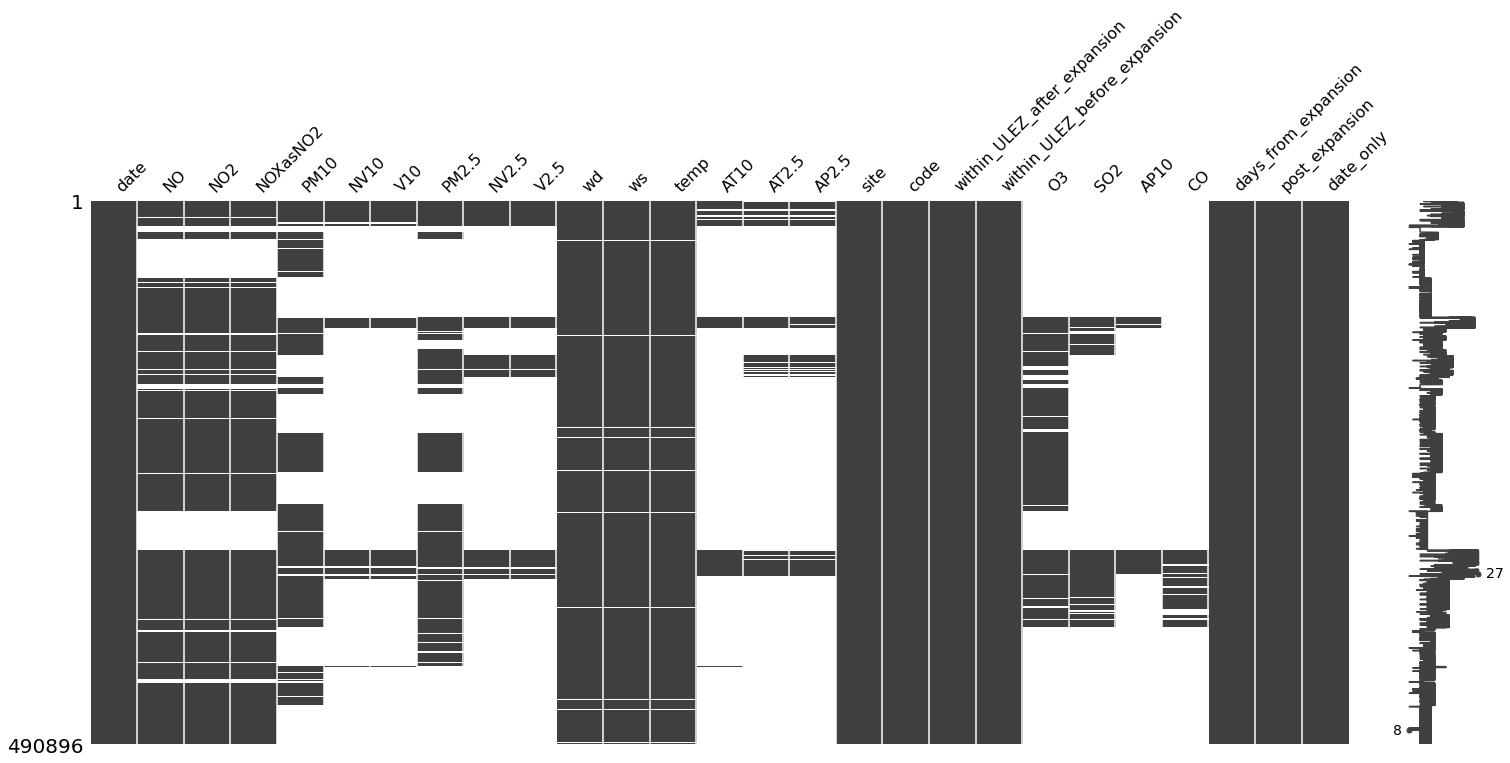

In [15]:
missingno.matrix(all_data)

We can see that imputation might be needed.  

Since the Regression Discontinuity Design our research adopts finds a cutoff on time, we might want to consider the influence of trend, seasonality, periodicality and noise as we do when conducting time series analysis.

An insight here is that the activity/inactivity of sites might also exhibit seasonality and periodicality, which might correspond with seasonality and periodicality of air quality. The rationale behind is that, maybe in winter days some air monitoring sites won't function, or some urban background monitors might close on holidays.  

What is ideal is, the pattern of how data is missing itself can give information about air quality trend, thereby facilitating the analysis rather than adding new complexities to the problem. Though the latter is very likely since I decided to delve into the pattern of "missing" when doing imputation if imputation is needed.

## More Data Preparation

Create variables for the introduction of cutoff

In [16]:
# Prepare the data
# Convert 'date' column to datetime
all_data['date'] = pd.to_datetime(all_data['date'])

# Create a variable representing days from the ULEZ expansion date
expansion_date = pd.to_datetime('2021-10-01')
all_data['days_from_expansion'] = (all_data['date'] - expansion_date).dt.days

# Create a binary indicator for post-expansion
all_data['post_expansion'] = (all_data['days_from_expansion'] >= 0).astype(int)

Calculate the 24-hour average of the data, so the seasonality within a day is eradicated

In [17]:
import pandas as pd

# Convert the 'date' column to datetime
all_data['date'] = pd.to_datetime(all_data['date'])

# Extract the date without the time component
all_data['date_only'] = all_data['date'].dt.date

# Group the data by 'site', 'date_only', and 'post_expansion', and calculate the mean for each group
# daily_data = all_data.groupby(['site', 'date_only', 'post_expansion']).mean().reset_index()
daily_data = all_data.groupby(['site', 'date_only', 'post_expansion']).mean().reset_index()

# Convert the 'date_only' column to datetime
daily_data['date_only'] = pd.to_datetime(daily_data['date_only'])

# Calculate the days_from_expansion for the daily_data
daily_data['days_from_expansion'] = (daily_data['date_only'] - pd.to_datetime('2021-10-25')).dt.days

# Display the daily_data DataFrame
daily_data.head()


,site,date_only,post_expansion,NO,NO2,NOXasNO2,PM10,NV10,V10,PM2.5,...,AT10,AT2.5,AP2.5,within_ULEZ_after_expansion,within_ULEZ_before_expansion,O3,SO2,AP10,CO,days_from_expansion
0,Camden Kerbside,2019-01-01,0,18.465249,32.667935,60.980920,14.241667,13.254167,0.987500,6.962500,...,9.062500,8.675000,1021.195833,1.0,0.0,NaN,NaN,NaN,NaN,-1028
1,Camden Kerbside,2019-01-02,0,78.767760,67.261416,188.036963,21.404167,20.329167,1.075000,8.641667,...,6.491667,5.622222,1027.533333,1.0,0.0,NaN,NaN,NaN,NaN,-1027
2,Camden Kerbside,2019-01-03,0,89.343680,73.043219,210.034954,23.787500,21.883333,1.904167,11.391667,...,5.829167,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,-1026
3,Camden Kerbside,2019-01-04,0,72.084123,60.201362,170.728808,35.758333,29.816667,5.941667,24.633333,...,4.137500,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,-1025
4,Camden Kerbside,2019-01-05,0,37.749597,56.269615,114.151523,28.845833,22.987500,5.858333,21.712500,...,5.750000,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,-1024


# 5 Preprocessing

## Linear Imputation

In [18]:
import pandas as pd

def impute_missing_values_by_site(data, site_col, columns_to_impute, method='linear', max_iterations=2):
    """
    Impute missing values in the specified columns for each site using the specified method.

    Args:
        data (pd.DataFrame): The DataFrame with missing values to be imputed.
        site_col (str): The name of the column containing site identifiers.
        columns_to_impute (list): The list of column names to be imputed.
        method (str): The imputation method ('linear', 'polynomial', 'pad', 'bfill', etc.).
        max_iterations (int): The maximum number of iterations for iterative imputation.

    Returns:
        pd.DataFrame: The DataFrame with imputed values.
    """
    imputed_data = []

    for site in data[site_col].unique():
        site_data = data[data[site_col] == site].copy()
        
        for _ in range(max_iterations):
            site_data[columns_to_impute] = site_data[columns_to_impute].interpolate(method=method)
            if site_data[columns_to_impute].isna().sum().sum() == 0:
                break
                
        imputed_data.append(site_data)
        
    return pd.concat(imputed_data)


In [19]:
# Specify the site column
site_col = 'site'  # replace with your site column name if different

# Specify the columns to be imputed
columns_to_impute = ['NO',
 'NO2',
 'NOXasNO2',
 'PM10',
 'NV10',
 'V10',
 'PM2.5',
 'NV2.5',
 'V2.5',
 'wd',
 'ws',
 'temp',
 'AT10',
 'AT2.5',
 'AP2.5',
 'O3',
 'SO2',
 'AP10',
 'CO']  # replace with your list of column names

# Choose the imputation method
method = 'linear'  # or any other method supported by DataFrame.interpolate

# Call the function to impute the missing values for each site
imputed_data = impute_missing_values_by_site(data=daily_data, site_col=site_col, columns_to_impute=columns_to_impute, method=method)


<AxesSubplot:>

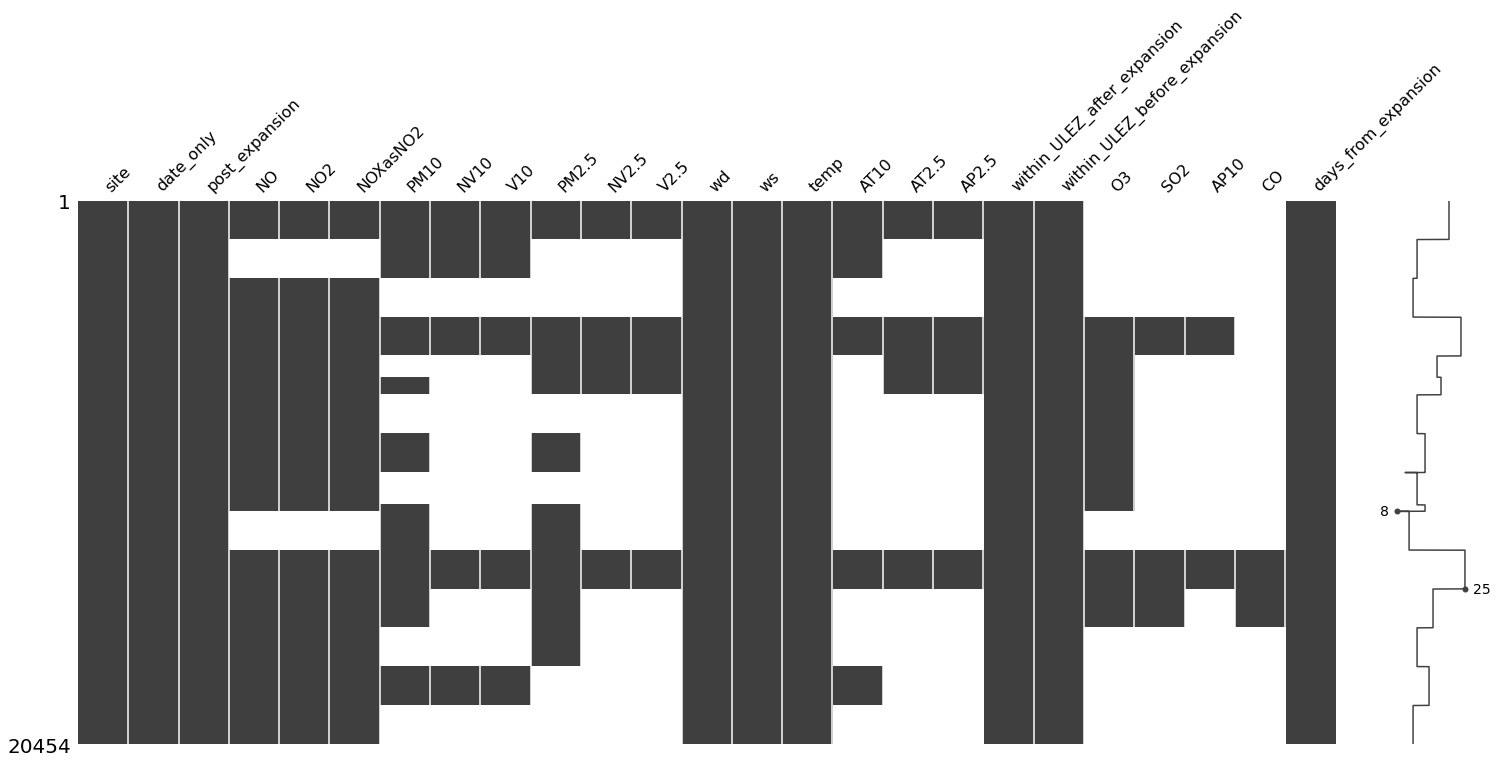

In [20]:
missingno.matrix(imputed_data)

It's obvious that iteration of lieanr interpolation can not deal with large chunks of missing data, because it can only fill missing values when there are valid data points before and after the missing section[]

pros and cons of ARIMA and Prophet:  

| Method | Pros | Cons |
| --- | --- | --- |
| ARIMA | 1. Widely used and well-understood | 1. Assumes linear relationship |
|  | 2. Handles stationary and non-stationary data | 2. Requires manual selection of parameters |
|  | 3. Models various types of relationships | 3. Sensitive to outliers and noise |
|  | 4. Suitable for short-term forecasts and linear patterns | 4. Doesn't perform well on data with multiple seasonality patterns or non-linear trends |
| Prophet | 1. Developed for forecasting at scale | 1. Relatively new and less widely adopted |
|  | 2. Automatically handles seasonalities, trends, and holiday effects | 2. Assumes additive model for seasonality and trend components |
|  | 3. Robust to outliers and missing data | 3. Requires installation of additional packages and dependencies |
|  | 4. Provides uncertainty intervals for forecasts | 4. Computationally more intensive than ARIMA, especially for large datasets |

In [21]:
!pip install statsmodels

## Time Series Imputation
As strong seasonality existing is assumed in the air quality dataAs strong seasonality existing is assumed in the air quality data

### ARIMA


In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def impute_with_arima(series, order=(1, 0, 0)):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    imputed = model_fit.predict(start=0, end=len(series)-1)
    return imputed

def impute_missing_values_arima(data, site_col, columns_to_impute, order=(1, 0, 0)):
    imputed_data = []

    for site in data[site_col].unique():
        site_data = data[data[site_col] == site].copy()
        
        for col in columns_to_impute:
            if site_data[col].isna().any():
                site_data[col] = impute_with_arima(site_data[col], order)

        imputed_data.append(site_data)
        
    return pd.concat(imputed_data)

imputed_data = impute_missing_values_arima(data=daily_data, site_col=site_col, columns_to_impute=columns_to_impute)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

### SARIMA
SARIMA (Seasonal Autoregressive Integrated Moving Average) is a time series forecasting method that combines the ARIMA model with seasonal adjustments. 
The SARIMA model can be represented as SARIMA(p, d, q)(P, D, Q)s, where:

p, d, and q are the orders of the non-seasonal AR, I, and MA components, respectively.
P, D, and Q are the orders of the seasonal AR, I, and MA components, respectively.
s is the seasonal period (e.g., 12 for monthly data with annual seasonality).

The following SARISMA takes too much time to run and is therefore commented out

In [23]:
# !pip install pmdarima

# from pmdarima import auto_arima

# def find_best_sarima_parameters(series, seasonal=True, seasonal_periods=12):
#     model = auto_arima(series, seasonal=seasonal, m=seasonal_periods, suppress_warnings=True)
#     order = model.order
#     seasonal_order = model.seasonal_order
#     return order, seasonal_order

# def impute_missing_values_auto_sarima(data, site_col, columns_to_impute, seasonal=True, seasonal_periods=12):
#     imputed_data = []

#     for site in data[site_col].unique():
#         site_data = data[data[site_col] == site].copy()

#         for col in columns_to_impute:
#             if site_data[col].isna().any():
#                 order, seasonal_order = find_best_sarima_parameters(site_data[col].dropna(), seasonal=seasonal, seasonal_periods=seasonal_periods)
#                 site_data[col] = impute_with_sarima(site_data[col], order, seasonal_order)

#         imputed_data.append(site_data)

#     return pd.concat(imputed_data)

# imputed_data = impute_missing_values_auto_sarima(data=daily_data, site_col=site_col, columns_to_impute=columns_to_impute)


In [24]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# def impute_with_sarima(series, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12)):
#     # order: (p, d, q) for ARIMA components
#     # p: AR (Autoregression) order - number of previous time steps (lags) in the model
#     # d: Differencing order - number of times the data is differenced to make it stationary
#     # q: MA (Moving Average) order - number of moving average terms

#     # seasonal_order: (P, D, Q, S) for Seasonal ARIMA components
#     # P: Seasonal AR order - number of seasonal autoregressive terms
#     # D: Seasonal differencing order - number of seasonal differences to make the time series stationary
#     # Q: Seasonal MA order - number of seasonal moving average terms
#     # S: Seasonal period length - number of periods per season (e.g., 12 for monthly data with yearly seasonality)

#     model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
#     model_fit = model.fit()
#     imputed = model_fit.predict(start=0, end=len(series)-1)
#     return imputed

# def impute_missing_values_sarima(data, site_col, columns_to_impute, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12)):
#     imputed_data = []

#     for site in data[site_col].unique():
#         site_data = data[data[site_col] == site].copy()
        
#         for col in columns_to_impute:
#             if site_data[col].isna().any():
#                 site_data[col] = impute_with_sarima(site_data[col], order, seasonal_order)

#         imputed_data.append(site_data)
        
#     return pd.concat(imputed_data)

# imputed_data = impute_missing_values_sarima(data=daily_data, site_col=site_col, columns_to_impute=columns_to_impute)


Let's take a look at how imputation went

<AxesSubplot:>

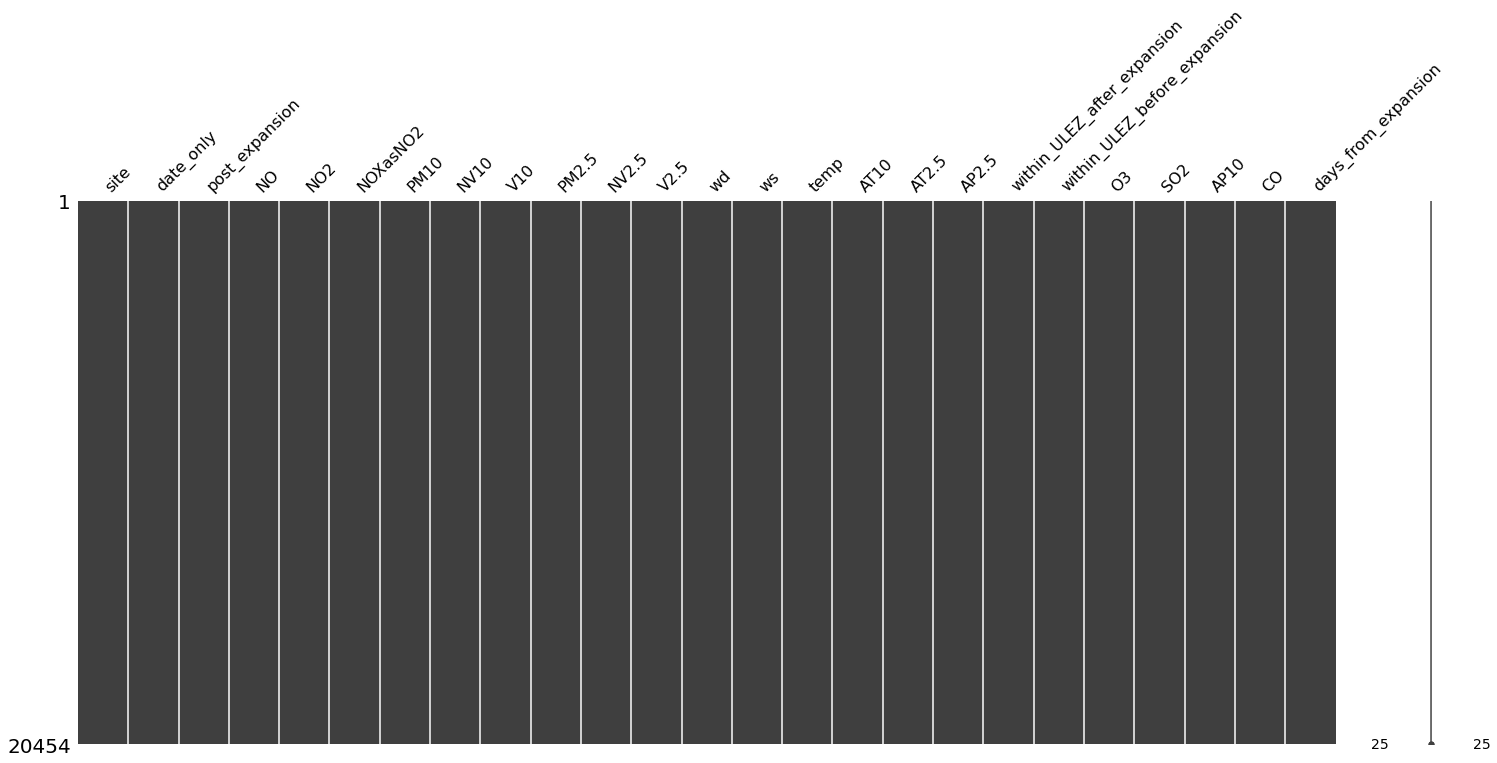

In [25]:
missingno.matrix(imputed_data)

Completeness is granted for our air quality indicators now. As for "wd", "ws" and "temp", they are variables this research don't take into consideration.  

But how about imputation quality? As I don't possess ground truth data, many options like RMSE score are disabled, which further research might address through using supplementary data sources other than openair.   

So let's just plot imputed data against original data visually.

In [26]:
# plot_imputation(daily_data, imputed_data, 'London Marylebone Road', 'NO', '2019-01-01', '2023-12-31')


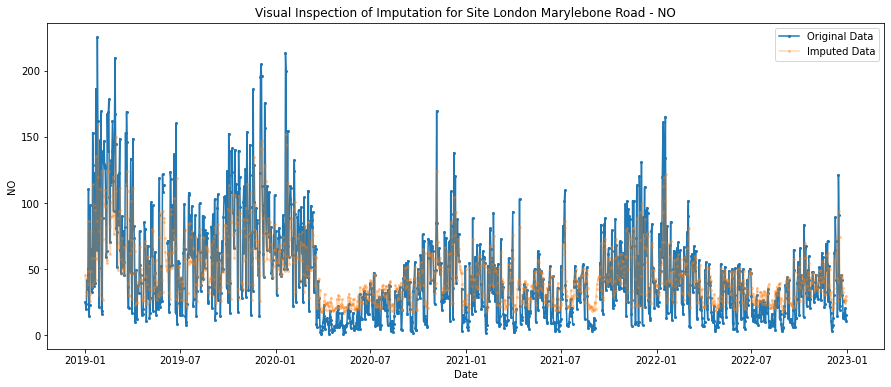

In [27]:
def plot_imputation(original_data, imputed_data, site_name, column, start_date, end_date):
    # Filter data for the specific site
    original_site_data = original_data[(original_data['site'] == site_name) & (original_data['date_only'] >= start_date) & (original_data['date_only'] <= end_date)]
    imputed_site_data = imputed_data[(imputed_data['site'] == site_name) & (imputed_data['date_only'] >= start_date) & (imputed_data['date_only'] <= end_date)]
    
    # Set up the plot
    plt.figure(figsize=(15, 6))
    
    # Plot the original data
    plt.plot(original_site_data['date_only'], original_site_data[column], label='Original Data', marker='o', linestyle='-', markersize=2)
    
    # Plot the imputed data
    plt.plot(imputed_site_data['date_only'], imputed_site_data[column], label='Imputed Data', marker='o', linestyle='-', markersize=2, alpha=0.3)
    
    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(f'Visual Inspection of Imputation for Site {site_name} - {column}')
    plt.legend()
    
    # Show the plot
    plt.show()
site_names = imputed_data.site.unique().tolist()
site_names
plot_imputation(daily_data, imputed_data, 'London Marylebone Road', 'NO', '2019-01-01', '2023-12-31')


For a particular site, a particular air quality indicator "NO" sees seemingly "natural" imputation at smaller gaps as we saw in interpolation, while imputed points in larger gaps seem rather smooth and might not capture reality information well, which might be due to a poor capture of seasonality. This might be addressed by further research to extract trend, periodicality and seasonality respectively when imputing.

The following cell adds site_id and site_name by merging imputed data with metadata

In [28]:
to_merge = metadata[["site_id","site_name"]].reset_index()
to_merge.drop(columns = ["rownames"], inplace = True)
imputed_data = pd.merge(left = imputed_data, right = to_merge, left_on = 'site', right_on = 'site_name')
# imputed_data
imputed_data.drop(columns = ['site_name'], inplace = True)

## EDA

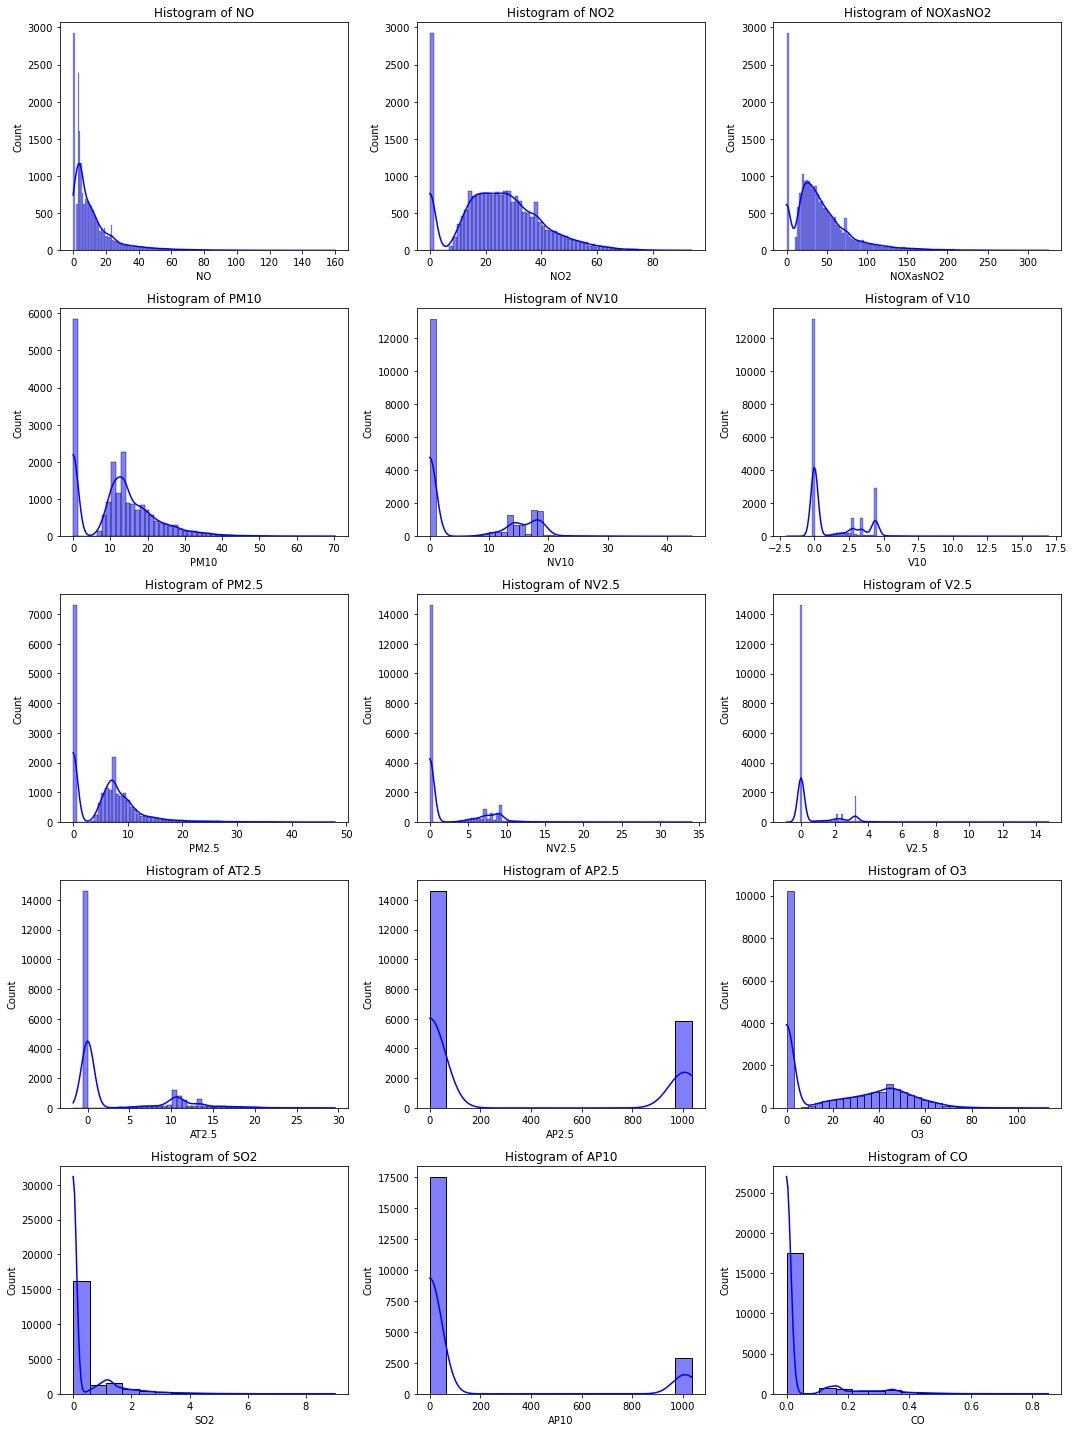

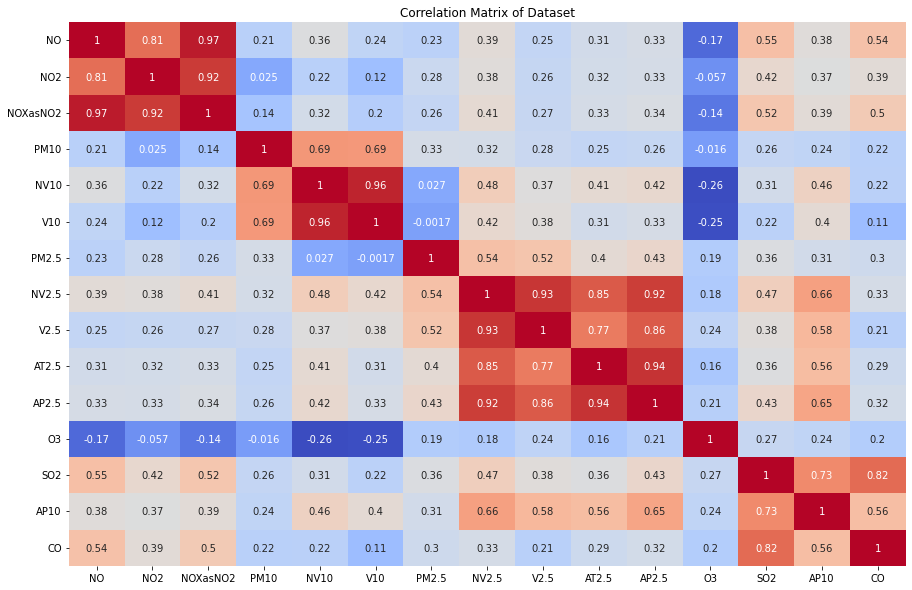

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_data_analysis(dataset, features_to_keep=None):
    if features_to_keep is None:
        features_to_keep = []

    def plot_histograms_for_each_feature(dataset, features_to_keep):
        features = features_to_keep

        fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
        for i, feature in enumerate(features):
            row = i // 3
            col = i % 3
            sns.histplot(dataset[feature], color='blue', kde=True, alpha=0.5, ax=axes[row, col])
            axes[row, col].set_title(f'Histogram of {feature}')
        plt.tight_layout()
        plt.show()

    def create_correlation_matrix(dataset, features_to_keep):
        dataset = dataset[features_to_keep]

        fig, ax = plt.subplots(figsize=(15, 10))
        sns.heatmap(dataset.corr(), cmap='coolwarm', annot=True, cbar=False, ax=ax)
        ax.set_title('Correlation Matrix of Dataset')

        plt.show()

    # Call internal functions
    plot_histograms_for_each_feature(dataset, features_to_keep)
    create_correlation_matrix(dataset, features_to_keep)

# Specify the air quality indicator columns
indicator_columns = ['NO', 'NO2', 'NOXasNO2', 'PM10', 'NV10', 'V10', 'PM2.5', 'NV2.5', 'V2.5', 'AT2.5', 'AP2.5', 'O3', 'SO2', 'AP10', 'CO']

# Example usage
plot_data_analysis(imputed_data, features_to_keep=indicator_columns)


Histograms indicate that the vast majority of 15 air pollutants shows a Gaussian distribution skewed to the left, with the exception of, e.g., V10, resembling Poisson distribution due to sparsity of data. This research approximately suppose they all follow skewed Gaussian distributions.  

The correlation matrix is very useful as it indicates 4 strong correlation groups, thus proffering potential directions of DR(Dimension Reduction). They are: 
1. NOx(NO, NO2, NOXasNO2)
2. PM10&Associated(PM10, NV10, V10) 
3. PM2.5_Associated('NV2.5', 'V2.5', 'AT2.5', 'AP2.5'), 
4. SO2('SO2', 'AP10', 'CO')
5. Uncategorised: PM2.5, O3

Some reasons behind this grouping are: NO, NO2, and NOXasNO2 are all nitrogen oxides and have similar sources. SO2 and CO are grouped together as they are both primarily emitted by industrial processes and combustion of fossil fuels.

## Feature Engineering

To narrow down feature number and expect for better Dimension Reduction results using linear techniques like PCA, instead of finding one feature representing all pollutants, I performed PCA on each of the group.

### Pollutants grouping

In [30]:
len(imputed_data.O3.unique())

10044

20454 NaNs detected


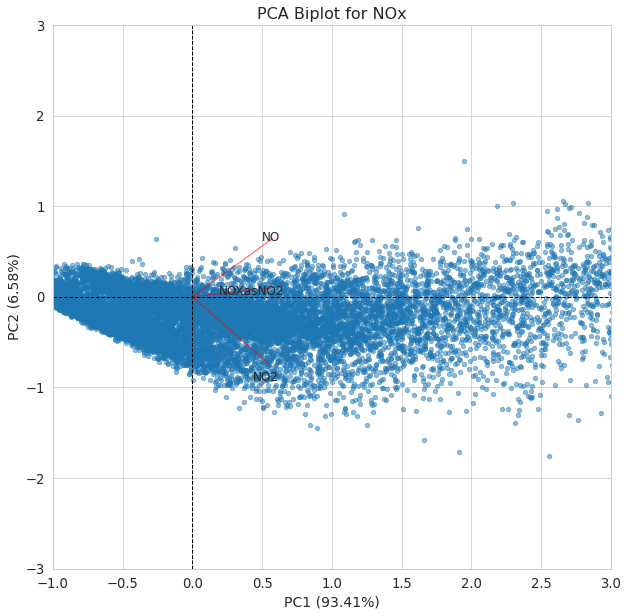

20454 NaNs detected


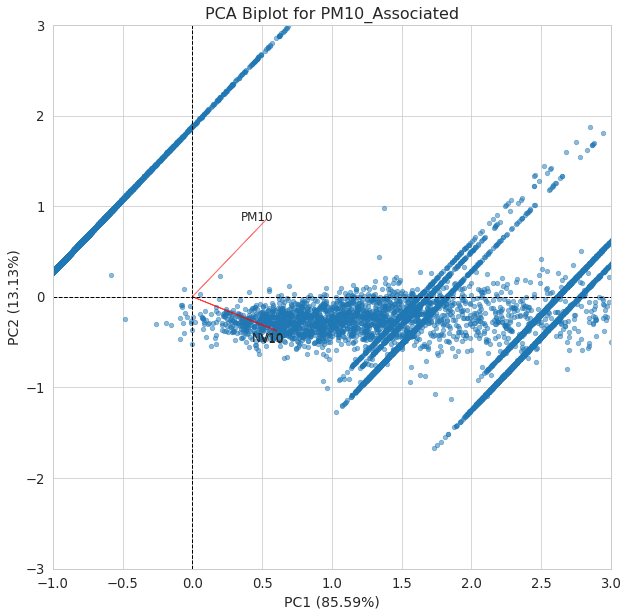

20454 NaNs detected


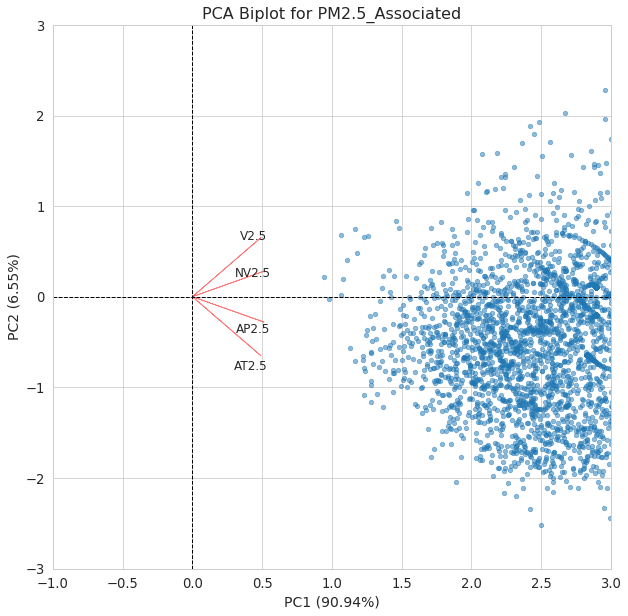

20454 NaNs detected


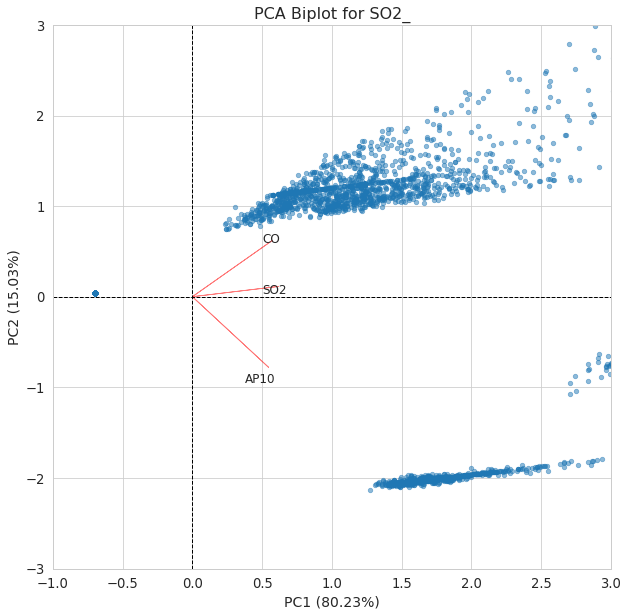

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_biplot(pca, X_new_components, columns, dataset_name):
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(X_new_components[:, 0], X_new_components[:, 1], s=20, alpha=0.5)

    max_x, max_y, min_x, min_y = 0, 0, 0, 0

    for i, column in enumerate(columns):
        ax.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='r', alpha=0.5)
        ax.text(pca.components_[0, i] * 1.1, pca.components_[1, i] * 1.1 + 0.02, column, fontsize=12, ha='right', va='top')

        max_x = max(max_x, pca.components_[0, i])
        max_y = max(max_y, pca.components_[1, i])
        min_x = min(min_x, pca.components_[0, i])
        min_y = min(min_y, pca.components_[1, i])

    ax.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0] * 100, 2)}%)', fontsize=14)
    ax.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1] * 100, 2)}%)', fontsize=14)
    ax.set_title(f'PCA Biplot for {dataset_name}', fontsize=16)

    # Adjust xlim and ylim based on red vectors
    xlim = (2 * np.floor(min_x) - 1, 2 * np.ceil(max_x) + 1)
    ylim = (2 * np.floor(min_y) - 1, 2 * np.ceil(max_y) + 1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=1)

    ax.grid(True)

    plt.savefig("biplot_publication_quality.png", dpi=300, bbox_inches='tight')

    plt.show()

from sklearn.preprocessing import StandardScaler

def group_pollutants_and_apply_pca(imputed_data, groupings):
    pca_results = pd.DataFrame(index=imputed_data.index)
    for group_name, pollutants in groupings.items():
       
        group_data = imputed_data[pollutants].dropna()
        print(f"{len(imputed_data[pollutants].isnull())} NaNs detected")

        # Standardize the data
        scaler = StandardScaler()
        standardized_group_data = scaler.fit_transform(group_data)

        pca = PCA(n_components=2)
        transformed_data = pca.fit_transform(standardized_group_data)
        
        plot_biplot(pca, transformed_data, pollutants, group_name)
        
        pca_single_component = PCA(n_components=1)
        transformed_data_single_component = pca_single_component.fit_transform(standardized_group_data)
        
        # Assign the PCA values to the original index positions in the pca_results DataFrame
        pca_results.loc[group_data.index, group_name] = transformed_data_single_component[:, 0]
    
    combined_data = pd.concat([imputed_data, pca_results], axis=1)
    
    return combined_data

# Example usage
pollutant_groups = {
    'NOx': ['NO', 'NO2', 'NOXasNO2'],
    'PM10_Associated': ['PM10', 'NV10', 'V10'],
    'PM2.5_Associated': ['NV2.5', 'V2.5', 'AT2.5', 'AP2.5'],
    'SO2_': ['SO2', 'AP10', 'CO']
}

combined_data = group_pollutants_and_apply_pca(imputed_data, pollutant_groups)


Across the four PCA biplots, we can observe that PC1 always explain over 80% of variance in the group. Also, all members within a group contribute positively to PC1. Therefore, selecting PC1 as the "representative" indicator of each group captures the information well. This is expeceted due to strong collinearity within each group.

Particularly, for group PM10_associated, it is obersavable that high correlation exists between PM10 and V10. Consecutive lines formed by points are visiable along the direction of the feature vector of PM10, as only two original features are used here, whose collinearity are preserved in the transferred space.

In [32]:
combined_data

,site,date_only,post_expansion,NO,NO2,NOXasNO2,PM10,NV10,V10,PM2.5,...,O3,SO2,AP10,CO,days_from_expansion,site_id,NOx,PM10_Associated,PM2.5_Associated,SO2_
0,Camden Kerbside,2019-01-01,0,23.709468,38.209451,74.689162,17.929566,14.780779,2.814735,10.150396,...,0.0,0.0,0.0,0.0,-1028,CA1,1.448628,1.483766,2.828784,-0.695972
1,Camden Kerbside,2019-01-02,0,20.460568,34.831040,66.196817,15.280689,13.730708,1.519080,7.881735,...,0.0,0.0,0.0,0.0,-1027,CA1,1.065327,0.845669,1.851364,-0.695972
2,Camden Kerbside,2019-01-03,0,57.819199,55.921117,144.908862,20.425239,18.597205,1.581124,9.076711,...,0.0,0.0,0.0,0.0,-1026,CA1,4.517032,1.503751,1.793956,-0.695972
3,Camden Kerbside,2019-01-04,0,64.371197,59.446020,158.536761,22.137096,19.666230,2.169069,11.033744,...,0.0,0.0,0.0,0.0,-1025,CA1,5.113177,1.864782,2.192514,-0.695972
4,Camden Kerbside,2019-01-05,0,53.678550,51.616922,134.186347,30.735288,25.123127,5.031979,20.457154,...,0.0,0.0,0.0,0.0,-1024,CA1,4.030203,3.655563,4.032399,-0.695972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20449,Tower Hamlets Roadside,2022-12-27,1,7.207671,17.599872,28.318425,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,428,TH2,-0.676789,-1.485915,-1.174431,-0.695972
20450,Tower Hamlets Roadside,2022-12-28,1,6.343652,15.715285,25.108724,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,429,TH2,-0.830184,-1.485915,-1.174431,-0.695972
20451,Tower Hamlets Roadside,2022-12-29,1,5.989017,12.369418,21.395646,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,430,TH2,-1.025999,-1.485915,-1.174431,-0.695972
20452,Tower Hamlets Roadside,2022-12-30,1,6.862708,15.686291,25.931446,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,431,TH2,-0.798391,-1.485915,-1.174431,-0.695972


In [33]:
combined_data.columns.tolist()

['site',
 'date_only',
 'post_expansion',
 'NO',
 'NO2',
 'NOXasNO2',
 'PM10',
 'NV10',
 'V10',
 'PM2.5',
 'NV2.5',
 'V2.5',
 'wd',
 'ws',
 'temp',
 'AT10',
 'AT2.5',
 'AP2.5',
 'within_ULEZ_after_expansion',
 'within_ULEZ_before_expansion',
 'O3',
 'SO2',
 'AP10',
 'CO',
 'days_from_expansion',
 'site_id',
 'NOx',
 'PM10_Associated',
 'PM2.5_Associated',
 'SO2_']

Need to clean column names

In [34]:
imputed_data.rename(columns=lambda x: x.replace(".", "_"), inplace=True)

combined_data.rename(columns=lambda x: x.replace(".", "_"), inplace=True)

indicator_columns =[s.replace('.', '_') for s in indicator_columns]

### Site type grouping (for presentation)

On the base of daily average, calculate average by location type: Suburban Background, Urban Background, Urban Industrial and Urban Traffic.

When aggregating the data, the fine-grained information such as within ULEZ zone or not, wind speed and wind direction for each site is lost. These columns have been useful in meteorological normalisation and shoud now be dropped.

In [35]:
# Merge daily_data and metadata DataFrames on the 'site' and 'site_name' columns
merged_data = pd.merge(imputed_data, metadata[['site_name', 'location_type']], left_on='site', right_on='site_name', how='left')

# Group the merged DataFrame by the 'location_type' column and compute the mean of each group
agg_data = merged_data.drop(columns=['within_ULEZ_after_expansion', 'within_ULEZ_before_expansion', 'ws', 'wd']).groupby(['date_only','location_type']).mean().reset_index()

agg_data.head(5)

,date_only,location_type,post_expansion,NO,NO2,NOXasNO2,PM10,NV10,V10,PM2_5,...,V2_5,temp,AT10,AT2_5,AP2_5,O3,SO2,AP10,CO,days_from_expansion
0,2019-01-01,Suburban Background,0.0,4.083521,14.780591,21.057249,10.941716,0.000000,0.000000,8.943780,...,3.222049,10.504742,0.000000,10.815292,1006.989698,44.314320,0.000000,0.000000,0.000000,-1028.0
1,2019-01-01,Urban Background,0.0,6.446080,20.993364,30.894328,9.642730,2.329201,0.573808,7.535745,...,0.535752,10.408888,1.703849,1.721847,167.987283,29.410921,0.422409,167.780728,0.027581,-1028.0
2,2019-01-01,Urban Industrial,0.0,8.931173,23.563373,37.257080,13.612775,0.000000,0.000000,8.244766,...,0.000000,10.179013,0.000000,0.000000,0.000000,42.958215,0.000000,0.000000,0.000000,-1028.0
3,2019-01-01,Urban Traffic,0.0,19.733147,29.654496,59.946332,14.365474,11.189946,2.391015,3.584123,...,0.750634,10.458104,8.591053,4.128943,334.830443,4.550179,0.426355,168.406852,0.057745,-1028.0
4,2019-01-02,Suburban Background,0.0,3.051724,13.123264,17.581903,10.941716,0.000000,0.000000,7.315917,...,1.898662,5.699375,0.000000,7.846159,1026.479862,46.636127,0.000000,0.000000,0.000000,-1027.0


In [36]:
print(f"post_expansion has unique values: {agg_data.post_expansion.unique()}")

print(f"location_type has unique values:{agg_data.location_type.unique()}")

print(f"days_from_expansion has unique values:{agg_data.days_from_expansion.unique()}")

post_expansion has unique values: [0. 1.]
location_type has unique values:['Suburban Background' 'Urban Background' 'Urban Industrial'
 'Urban Traffic']
days_from_expansion has unique values:[-1028. -1027. -1026. ...   430.   431.   432.]


Now that my data completeness problem was handled in section time series imputation, we can 
* use dimensionality reduction techniques to visualise information hidden in higher dimension using t-SNE and U-map
* and explore potential further dimension reduction through PCA.

## t-SNE
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique that is particularly useful for visualizing high-dimensional data.


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


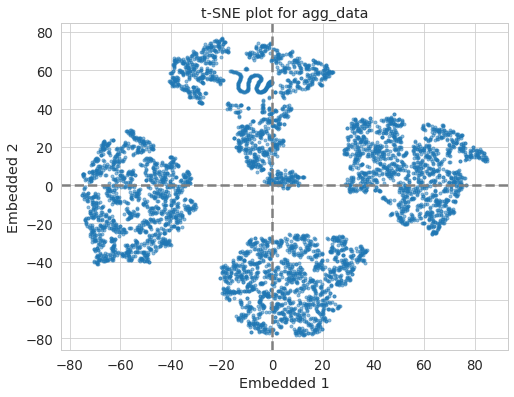

In [37]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define a function to perform t-SNE
def perform_tsne(df, columns, n_components=2, perplexity=30, learning_rate=200, n_iter=1000):
    # Standardize the data
    standardized_data = StandardScaler().fit_transform(df[columns])

    # Perform t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    embedded_data = tsne.fit_transform(standardized_data)
    
    # Create a DataFrame with the embedded data
    embedded_columns = [f'Embedded{i+1}' for i in range(embedded_data.shape[1])]
    embedded_df = pd.DataFrame(data=embedded_data, columns=embedded_columns)
    
    return embedded_df, tsne, embedded_data

# Plot t-SNE results
def plot_tsne(embedded_data, title="t-SNE plot"):
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], alpha=0.5, s=10)
    plt.axhline(0, color='gray', linestyle='dashed')
    plt.axvline(0, color='gray', linestyle='dashed')
    plt.xlabel('Embedded 1')
    plt.ylabel('Embedded 2')
    plt.title(title)
    plt.show()


# # Perform t-SNE on daily_data
# daily_embedded_df, daily_tsne, daily_embedded_data = perform_tsne(imputed_data, indicator_columns)
# print(daily_embedded_df.head())

# Perform t-SNE on agg_data

agg_embedded_df, agg_tsne, agg_embedded_data = perform_tsne(agg_data, indicator_columns)
agg_embedded_df.head()

grouped_cols = ['NOx',
 'PM10_Associated',
 'PM2_5',
 'PM2_5_Associated',
 'O3',
 'SO2_']

# Perform t-SNE on agg_data
comb_embedded_df, comb_embedded_tsne, comb_embedded_data = perform_tsne(combined_data, grouped_cols)
comb_embedded_df.head()

# Plot t-SNE results for daily_data
# plot_tsne(daily_embedded_data, title="t-SNE plot for daily_data")

# Plot t-SNE results for agg_data
plot_tsne(agg_embedded_data, title="t-SNE plot for agg_data")

# Plot t-SNE results for combined_data
# plot_tsne(comb_embedded_data, title="t-SNE plot for combined data")


t-SNE aims to preserve the local structure of the data. As there are four distinct clusters in two-dimensional space, we can assume that urban traffic, urban background, urban industry and suburban are a categorisation that captures similarity of data points in the high-dimensional space. In this case, that is the 15-dimension space of air quality indicators.  
So categorising sites according to location types is supported by t-SNE analysis. Later, in effect presentation, treatment effect of the policy will be presented according to this grouping.

## U-Map

U-Map here can help us catch a glimpse of high-dimensional relationships in a low-demension plot, serving the similar purpose of t-SNE except for preserved local information. The produced plot could generate the same insight as we did with t-SNE. Besides, the code takes too much time and is therefore commented out.

In [38]:
# !pip install umap-learn
# from umap import UMAP

# # Define a function to perform UMAP
# def perform_umap(df, columns, n_components=2, n_neighbors=15, min_dist=0.1, random_state=42):
#     # Standardize the data
#     standardized_data = StandardScaler().fit_transform(df[columns])

#     # Perform UMAP
#     umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
#     umap_components = umap.fit_transform(standardized_data)
    
#     # Create a DataFrame with the UMAP components
#     umap_columns = [f'UMAP{i+1}' for i in range(umap_components.shape[1])]
#     umap_df = pd.DataFrame(data=umap_components, columns=umap_columns)
    
#     return umap_df, umap, umap_components
# # # Perform UMAP on daily_data
# # daily_umap_df, daily_umap, daily_umap_cpnts = perform_umap(imputed_data, indicator_columns)
# # print(daily_umap_df.head())

# # # Plot scatter plot for daily_data
# # plt.figure(figsize=(10, 10))
# # plt.scatter(daily_umap_cpnts[:, 0], daily_umap_cpnts[:, 1], s=10, alpha=0.5)
# # plt.xlabel('UMAP1')
# # plt.ylabel('UMAP2')
# # plt.title('UMAP for Daily Averaged Data')
# # plt.show()


# # Perform UMAP on daily_data
# agg_umap_df, agg_umap, agg_umap_cpnts = perform_umap(agg_data, indicator_columns)
# print(daily_umap_df.head())

# # Plot scatter plot for daily_data
# plt.figure(figsize=(10, 10))
# plt.scatter(agg_umap_cpnts[:, 0], agg_umap_cpnts[:, 1], s=10, alpha=0.5)
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.title('UMAP for Location Type Aggregated Data')
# plt.show()


## One principle component?

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.751351 -0.817040  0.791737  2.162936  0.430629 -0.015477 -0.788860   
1  1.673254 -0.354878  0.670159  1.749952  0.148368 -0.158597 -0.819470   
2  3.455078  1.944962  1.762910  2.598772  0.811646  1.024836 -0.768248   
3  4.169408  2.041573  1.938312  2.864886  1.138037  1.193472 -0.642932   
4  5.834448 -0.387311  2.098131  2.827446  2.482860  0.841623  0.314856   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.217557 -0.269747  0.325710  0.115747  0.168059 -0.025923 -0.041889   
1 -0.580867 -0.028386  0.318688  0.174890  1.071024 -0.124377 -0.086765   
2 -0.148542  0.650752 -0.123284  0.696187  1.332784 -0.232872  0.171800   
3  0.123416  0.637254 -0.203939  0.835852  1.209625 -0.147654  0.099903   
4  1.425826 -0.125606 -0.393444  0.768156  0.938366  0.183587 -0.066428   

       PC15  
0  0.000122  
1  0.003561  
2 -0.021875  
3 -0.029733  
4 -0.031486  


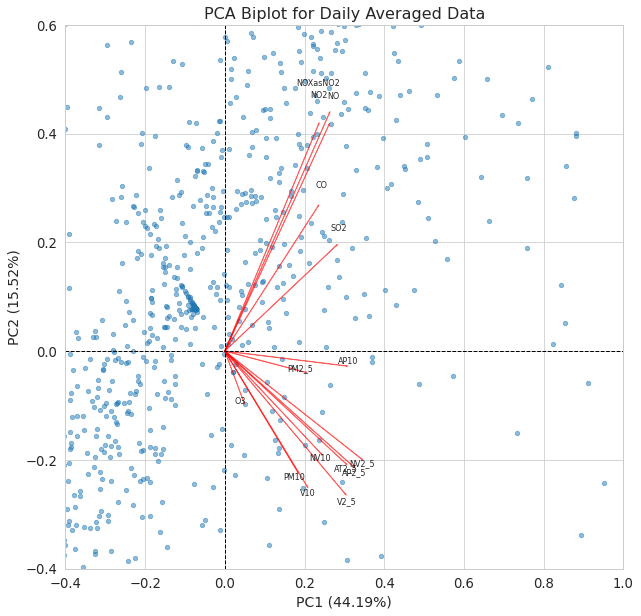

Explained variance ratio of each component in daily averaged data:
[4.41915910e-01 1.55199187e-01 1.44211160e-01 8.76805917e-02
 5.89276426e-02 3.76494308e-02 2.60685735e-02 1.55255694e-02
 1.17257474e-02 8.08900241e-03 6.45380837e-03 3.45211773e-03
 2.40418657e-03 6.80708621e-04 1.63644400e-05]
Eigenvalues of each component in daily averaged data:
[6.62906274e+00 2.32810163e+00 2.16327316e+00 1.31527318e+00
 8.83957856e-01 5.64769074e-01 3.91047721e-01 2.32894928e-01
 1.75894811e-01 1.21340968e-01 9.68118587e-02 5.17842978e-02
 3.60645618e-02 1.02111285e-02 2.45478602e-04]


In [39]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to perform PCA
def perform_pca(df, columns, n_components=None):
    # Standardize the data
    standardized_data = StandardScaler().fit_transform(df[columns])

    # Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(standardized_data)
    
    # Create a DataFrame with the principal components
    pca_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
    pca_df = pd.DataFrame(data=principal_components, columns=pca_columns)
    
    return pca_df, pca, principal_components

def plot_biplot(pca, X_new_components, columns, dataset_name, xlim=(-1, 1), ylim=(-1, 1)):
    # Set the style and context for a publication-quality plot
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

    fig, ax = plt.subplots(figsize=(10, 10))

    # Scatter plot of the principal components
    ax.scatter(X_new_components[:, 0], X_new_components[:, 1], s=20, alpha=0.5)

    # Add variable labels
    for i, column in enumerate(columns):
        ax.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='r', alpha=0.5)
        ax.text(pca.components_[0, i] * 1.1, pca.components_[1, i] * 1.1 + 0.02, column, fontsize=8, ha='right', va='top')

    # Set plot labels
    ax.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0] * 100, 2)}%)', fontsize=14)
    ax.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1] * 100, 2)}%)', fontsize=14)
    ax.set_title(f'PCA Biplot for {dataset_name}', fontsize=16)

    # Set axis limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Add dashed lines at x = 0 and y = 0
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=1)

    # Add a grid
    ax.grid(True)

    # Save the plot to a file
    plt.savefig("biplot_publication_quality.png", dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()


# Specify the air quality indicator columns
indicator_columns = ['NO', 'NO2', 'NOXasNO2', 'PM10', 'NV10', 'V10', 'PM2.5', 'NV2.5', 'V2.5', 'AT2.5', 'AP2.5', 'O3', 'SO2', 'AP10', 'CO']
    
indicator_columns = [col.replace(".", "_") for col in indicator_columns]

# Perform PCA on daily_data
daily_pca_df, daily_pca, daily_pca_cpnts = perform_pca(imputed_data, indicator_columns)
print(daily_pca_df.head())

# Plot biplot for daily_data
plot_biplot(daily_pca, daily_pca_cpnts, indicator_columns, 'Daily Averaged Data', xlim=(-0.4, 1), ylim=(-0.4, 0.6))

print('Explained variance ratio of each component in daily averaged data:')
print(daily_pca.explained_variance_ratio_)

print('Eigenvalues of each component in daily averaged data:')
print(daily_pca.explained_variance_)


Intepretation: all 15 air indicators contribute positvely to the first Principle component, despite a low Explained Variance Ratio of 44.19%, which indicates potential non-linear relationship omitted by PCA as it can only capture information through linear combinations of original variables. This might call for kernel methods. [kPCA]. As for the 2nd Principle Component, 


PCA itself is good at capturing the linear combination of the original dataset, despite that it's deterministic, i.e., given the same data the output is determined. This means the Here we have a dilemma: the first Principle component only explains 44.19% percent of variance in the original daily averaged data 15-dimension space. If we adopr Kernel PCA, the explained variance can not be quantified.

Solution: 
1. Go back to look into the data space, and choose from PCA variants like sparse PCA and Robust PCA.
2. Try different standardisation methods normalisation
3. Through identifying collinearity, try to merge columns or drop columns that overlap in inforamtion capturable by linear combinations in PCA

And through doing solution 3, now we have four pollutant groups along with two independent air pollutants, see

In [40]:
# imputed_data['PCA1'] = daily_pca_df['PC1']
# agg_data['PCA1'] = agg_pca_df['PC1']

In [41]:
# # Perform PCA on agg_data
# agg_pca_df, agg_pca, agg_pca_cpnts = perform_pca(agg_data, indicator_columns)
# agg_pca_df.head()

# # Plot biplot for agg_data
# plot_biplot(agg_pca, daily_pca_cpnts, indicator_columns,'Location type aggregated data',xlim=(-0.4, 1), ylim=(-0.4, 0.6))

# print('Explained variance ratio of each component in location type categorised data:')
# print(agg_pca.explained_variance_ratio_)

# print('Eigenvalues of each component in location type categorised data:')
# print(agg_pca.explained_variance_)

In [42]:
# import pandas as pd
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# def perform_tsne2(pca_df, n_components=2, perplexity=30, random_state=42):
#     tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
#     tsne_results = tsne.fit_transform(pca_df)
#     return tsne_results

# def plot_tsne(tsne_results, title):
#     plt.figure(figsize=(8, 6))
#     plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
#     plt.xlabel('t-SNE 1')
#     plt.ylabel('t-SNE 2')
#     plt.title(title)
#     plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
#     plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
#     plt.show()

# # Perform t-SNE on the PCA results
# daily_tsne_results = perform_tsne2(daily_pca_df)
# agg_tsne_results = perform_tsne2(agg_pca_df)

# # Visualize the t-SNE results
# plot_tsne(daily_tsne_results, title='t-SNE Visualization of Daily Data PCA Results')
# plot_tsne(agg_tsne_results, title='t-SNE Visualization of Aggregated Data PCA Results')


<!-- ## Robust PCA -->

In [43]:
# !pip install r_pca
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from r_pca import R_pca

# def perform_rpca(df, columns, n_components=None):
#     # Standardize the data
#     standardized_data = StandardScaler().fit_transform(df[columns])

#     # Perform Robust PCA
#     rpca = R_pca(standardized_data)
#     principal_components, _ = rpca.fit()

#     # Create a DataFrame with the principal components
#     pca_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
#     pca_df = pd.DataFrame(data=principal_components, columns=pca_columns)

#     return pca_df, rpca, principal_components

# # Perform Robust PCA on daily_data
# daily_rpca_df, daily_rpca, daily_rpca_cpnts = perform_rpca(imputed_data, indicator_columns)
# print(daily_rpca_df.head())


In [44]:
# daily_umap_df

In [45]:
# imputed_data['UMAP1'] = daily_umap_df['UMAP1']
# agg_data['UMAP1'] = agg_umap_df['UMAP1']

<!-- ## K-PCA -->

In [46]:
# import pandas as pd
# from sklearn.decomposition import KernelPCA
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Define a function to perform Kernel PCA
# def perform_kernel_pca(df, columns, n_components=None, kernel='rbf', gamma=None):
#     # Standardize the data
#     standardized_data = StandardScaler().fit_transform(df[columns])

#     # Perform Kernel PCA
#     kpca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma)
#     principal_components = kpca.fit_transform(standardized_data)
    
#     # Create a DataFrame with the principal components
#     kpca_columns = [f'KPC{i+1}' for i in range(principal_components.shape[1])]
#     kpca_df = pd.DataFrame(data=principal_components, columns=kpca_columns)
    
#     return kpca_df, kpca, principal_components

# # Perform Kernel PCA on daily_data
# daily_kpca_df, daily_kpca, daily_kpca_cpnts = perform_kernel_pca(imputed_data, indicator_columns, n_components=2, kernel='rbf', gamma=None)
# print(daily_kpca_df.head())

# # Plot biplot for daily_data with Kernel PCA
# plot_biplot(daily_kpca, daily_kpca_cpnts, indicator_columns, 'Daily Averaged Data', xlim=(-0.4, 1), ylim=(-0.4, 0.6))


# # Perform Kernel PCA on agg_data
# agg_kpca_df, agg_kpca, agg_kpca_cpnts = perform_kernel_pca(agg_data, indicator_columns, n_components=2, kernel='rbf', gamma=None)
# print(agg_kpca_df.head())

# # Plot biplot for agg_data with Kernel PCA
# plot_biplot(agg_kpca, agg_kpca_cpnts, indicator_columns, 'Aggregated Data', xlim=(-0.4, 1), ylim=(-0.4, 0.6))

In [47]:
# imputed_data['rbf1'] = daily_kpca_df['KPC1']
# agg_data['rbf1'] = agg_kpca_df['KPC1']

# 6 Analysis

RDD assumptions:
1. Continuity of potential outcomes: The potential outcomes, air quality indicators are continuous functions of the running variable (days_from_expansion) in the absence of the treatment (ULEZ expansion).

2. Cutoff-based treatment assignment is met since the treatment(ULEZ expansion) is assigned based on the expansion date.

3. No manipulation of the running variable: Individuals (or observational units) should not be able to manipulate the running variable to influence their treatment status. This assumption is met here since the running variable (days_from_expansion) is based on time, which cannot be manipulated by the observational units (air quality monitoring stations).

4. No other confounding factors: There should be no other factors affecting the outcome variable at the same time as the treatment is assigned. Might be persisting confounders such as seasonality, periodicality and trend in time. ARIMA created a time series seemingly has these confounders handled.

5. Sufficient sample size and data density around the cutoff: There should be enough observations around the cutoff to allow for a reliable estimation of the treatment effect. With entry scale at 10^5 in data, sample scale and point density should be enough in around cutoff after imputation.

6. Correct functional form of the model: The model used in the RDD analysis should correctly capture the functional relationship between the running variable and the outcome. A linear model with the same slope, a linear model with different slopes and a polynomial model, are planned to be performed for robustness testing.


Here I adopted an RDD deisgn taking into a lagged effect of the policy into consideration , as [ma_has_2021] suggest that the air pollutant concentrations tend to need a transient period to reach their response ratio caps. These periods range from 3-9 weeks varying according to both pollutant species and site types.

## RDD

<!-- ### Linear, same slope -->

In [48]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# lin_diffSlop = smf.ols('NO ~ days_from_expansion + post_expansion * days_from_expansion', data=imputed_data).fit()

# # Create a scatter plot of the data
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.scatterplot(data=imputed_data, x='days_from_expansion', y='NO', hue='post_expansion', alpha=0.3, ax=ax)

# # Generate x values for the model line
# x_values = np.linspace(imputed_data['days_from_expansion'].min(), imputed_data['days_from_expansion'].max(), num=100)

# # Calculate predicted y values for the model line before expansion
# y_values_before_expansion = lin_diffSlop.params['Intercept'] + lin_diffSlop.params['days_from_expansion'] * x_values

# # Calculate predicted y values for the model line after expansion
# y_values_after_expansion = (lin_diffSlop.params['Intercept'] +
#                             lin_diffSlop.params['days_from_expansion'] * x_values +
#                             lin_diffSlop.params['post_expansion'] +
#                             lin_diffSlop.params['post_expansion:days_from_expansion'] * x_values)



# # Plot the model lines
# ax.plot(x_values, y_values_before_expansion, color='blue', linewidth=2, label='Fitted model (before expansion)')
# ax.plot(x_values, y_values_after_expansion, color='red', linewidth=2, label='Fitted model (after expansion)')
# ax.legend()

# # Set the plot labels
# ax.set_xlabel('Days from expansion')
# ax.set_ylabel('NO')
# ax.set_title('NO vs. Days from expansion')

# plt.show()

# def rdd_estimate(fitted_model, expansion_date=0):
#     y_before_expansion = fitted_model.predict(pd.DataFrame({'days_from_expansion': [expansion_date - 1e-6], 'post_expansion': 0}))[0]
#     y_after_expansion = fitted_model.predict(pd.DataFrame({'days_from_expansion': [expansion_date + 1e-6], 'post_expansion': 1}))[0]
#     alpha_srdd = y_after_expansion - y_before_expansion
#     alpha_srdd_percentage = (alpha_srdd / y_before_expansion) * 100
#     return alpha_srdd, alpha_srdd_percentage



For NO, an individual pollutant, there seems to be already observable discontinuity using the simplest linear models. Following this example, we perform RDD with exclusion of time periods immediate to the treatment 

To define the treatment variable $D_i$:
> $$D_i = \begin{cases} 
           0, & x_i < x_c \\
           1, & x_i > x_c \\
        \end{cases}$$
        where $x_i$ is the value for the running variable, while x_c being the cutoff.

Doing RDD we mainly use OLS(Ordinary Least Squares) models featuring the following formulai (Cattaneo, Idrobo, and Titiunik, 2019; Imbens and Lemieux, 2008):

* linear, same slope:

$$
Y_i = \gamma + \alpha *D_i + \beta*X_i + \epsilon_i
$$

* linear, different slopes: 

$$
Y_i = \gamma + \alpha*D_i + \beta_0X_i + \beta_1(X_i * D_i) + \epsilon_i
$$

* Non-linear (quadratic):

$$
Y_i = \gamma_0 + \gamma_1X_i + \gamma_2X_i^2 + \alpha_0D_i + \alpha_1(X_i * D_i) + \alpha_2(X_i^2 * D_i) + \epsilon_i
$$

In the formulai above, $\alpha$, $\beta$, $\gamma$ and their variants are what the models need to capture.

Metric for quantification:

For quantifying the effect of the policy, I use:

> $${\alpha}SRDD = \\  \operatorname{E}\left[Y_i\left(1\right)-Y_i\left(0\right)\mid X_i=c\right] = \\  \lim_{x\to c^-}\operatorname{E}\left[Y_i\left|\,X_i=c\right.\right] - \lim_{x\to c^+}\operatorname{E}\left[Y_i\left|\,X_i=c\right.\right]$$

In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
lin_sameSlop = smf.ols('PM2_5 ~ days_from_expansion + post_expansion', data=imputed_data).fit()

print(lin_sameSlop.summary())

                            OLS Regression Results                            
Dep. Variable:                  PM2_5   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     44.27
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           6.54e-20
Time:                        16:20:10   Log-Likelihood:                -65257.
No. Observations:               20454   AIC:                         1.305e+05
Df Residuals:                   20451   BIC:                         1.305e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.5352    

From an initial model summary, we can see that the treatment variable "days_from_expansion" has a very minor effect on the running variable, and this is statistically significant.  

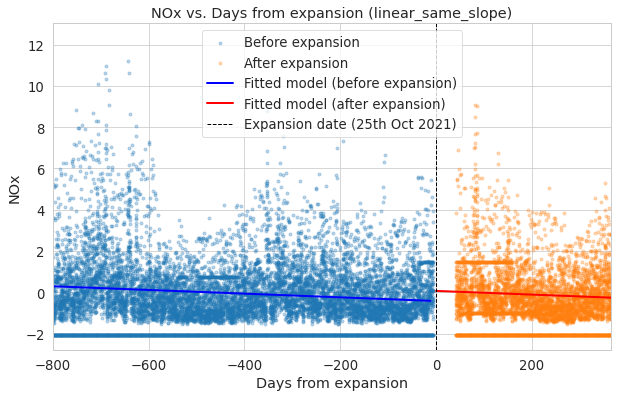

RDD estimate using linear_same_slope model: 0.4897 (-116.57%)


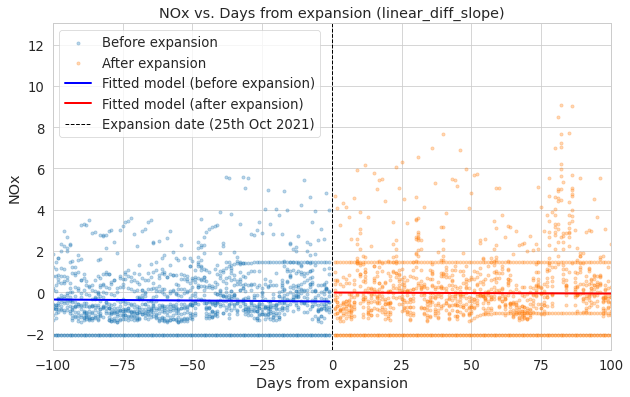

RDD estimate using linear_diff_slope model: 0.4314 (-97.68%)


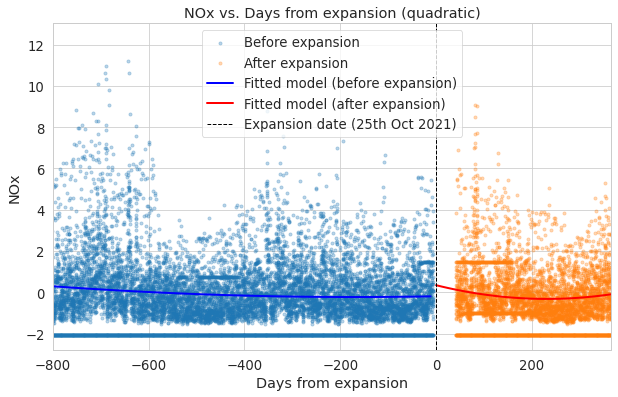

RDD estimate using quadratic model: 0.5354 (-283.50%)


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

def rdd_estimate(fitted_model):
    rdd_value = fitted_model.params['post_expansion']
    rdd_percentage = 100 * rdd_value / fitted_model.params['Intercept']
    return rdd_value, rdd_percentage


def plot_rdd(data, outcome_var='NO', model_type='linear_same_slope', x_min=None, x_max=None, transient_period_before=0, transient_period_after=0, plot=True):
    # Filter the data to exclude the transient periods before and after the expansion
    data = data[((data['days_from_expansion'] < -transient_period_before) | (data['days_from_expansion'] > transient_period_after))]    
    if model_type == 'linear_same_slope':
        model_formula = f'{outcome_var} ~ days_from_expansion + post_expansion'
    elif model_type == 'linear_diff_slope':
        model_formula = f'{outcome_var} ~ days_from_expansion + post_expansion * days_from_expansion'
    elif model_type == 'quadratic':
        model_formula = f'{outcome_var} ~ days_from_expansion * post_expansion + np.power(days_from_expansion, 2) * post_expansion'
    else:
        raise ValueError("Invalid model_type. Allowed values are 'linear_same_slope', 'linear_diff_slope', and 'quadratic'.")

    fitted_model = smf.ols(model_formula, data=data).fit()

    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Split the data into two subsets, one for before and one for after the expansion
        data_before_expansion = data[data['days_from_expansion'] <= 0]
        data_after_expansion = data[data['days_from_expansion'] > 0]

        # Create separate scatter plots for the data before and after the expansion
        ax.scatter(data_before_expansion['days_from_expansion'], data_before_expansion[outcome_var], alpha=0.3, s=10, label='Before expansion')
        ax.scatter(data_after_expansion['days_from_expansion'], data_after_expansion[outcome_var], alpha=0.3, s =10, label='After expansion')

        if x_min is None:
            x_min = data['days_from_expansion'].min()
        if x_max is None:
            x_max = data['days_from_expansion'].max()

        x_values = np.linspace(x_min, x_max, num=100)
        y_values_before_expansion = fitted_model.predict(pd.DataFrame({'days_from_expansion': x_values, 'post_expansion': 0}))
        y_values_after_expansion = fitted_model.predict(pd.DataFrame({'days_from_expansion': x_values, 'post_expansion': 1}))

        expansion_date = 0
        ax.plot(x_values[x_values <= expansion_date], y_values_before_expansion[x_values <= expansion_date], color='blue', linewidth=2, label='Fitted model (before expansion)')
        ax.plot(x_values[x_values > expansion_date], y_values_after_expansion[x_values > expansion_date], color='red', linewidth=2, label='Fitted model (after expansion)')

        ax.axvline(x=expansion_date, color='black', linestyle='--', linewidth=1, label='Expansion date (25th Oct 2021)')

        ax.legend()

        ax.set_xlim(x_min, x_max)
        ax.set_xlabel('Days from expansion')
        ax.set_ylabel(outcome_var)
        ax.set_title(f'{outcome_var} vs. Days from expansion ({model_type})') 
        plt.show()

    rdd_value, rdd_percentage = rdd_estimate(fitted_model)
    print(f"RDD estimate using {model_type} model: {rdd_value:.4f} ({rdd_percentage:.2f}%)")
    
    return fitted_model, (rdd_value, rdd_percentage)

    
linear_same_slope = plot_rdd(combined_data, outcome_var='NOx', model_type='linear_same_slope', x_min=-800, x_max=365, transient_period_before=5, transient_period_after=40)
linear_diff_slope = plot_rdd(combined_data, outcome_var='NOx', model_type='linear_diff_slope', x_min=-100, x_max=100)
quadratic = plot_rdd(combined_data, outcome_var='NOx', model_type='quadratic', x_min=-800, x_max=365, transient_period_before=5, transient_period_after=40)

We can tell from scatter plot that seansonality still needs coping with. Also, as for NOx, the three models rather suggest an increase in concentration at the cutoff. This might require further seaasonality elimination techniques in the later analysis.

For the first and the third graph in this section, transient time was selected as ma_has_2021 suggested a 5-8 weeks of lagged effect of ULEZ initiation. Further validation and tailoring to the expansion situation are needed.

## Effect presentation

In [51]:
combined_data.columns

Index(['site', 'date_only', 'post_expansion', 'NO', 'NO2', 'NOXasNO2', 'PM10',
       'NV10', 'V10', 'PM2_5', 'NV2_5', 'V2_5', 'wd', 'ws', 'temp', 'AT10',
       'AT2_5', 'AP2_5', 'within_ULEZ_after_expansion',
       'within_ULEZ_before_expansion', 'O3', 'SO2', 'AP10', 'CO',
       'days_from_expansion', 'site_id', 'NOx', 'PM10_Associated',
       'PM2_5_Associated', 'SO2_'],
      dtype='object')

RDD estimate using linear_same_slope model: 0.4716 (48.69%)
RDD estimate using linear_same_slope model: -0.0474 (3.71%)
RDD estimate using linear_same_slope model: 0.0558 (-8.14%)
RDD estimate using linear_same_slope model: 0.3749 (32.88%)
RDD estimate using linear_same_slope model: -0.0224 (3.28%)
RDD estimate using linear_same_slope model: 0.0120 (-1.73%)
RDD estimate using linear_same_slope model: -0.0473 (6.72%)


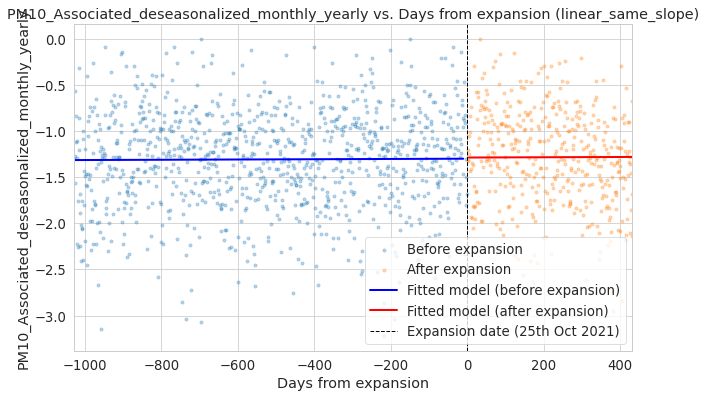

RDD estimate using linear_same_slope model: 0.0127 (-0.98%)
RDD estimate using linear_same_slope model: -0.1417 (11.53%)
RDD estimate using linear_same_slope model: -0.1132 (16.02%)
RDD estimate using linear_same_slope model: 0.2013 (16.23%)
RDD estimate using linear_same_slope model: -0.1206 (9.51%)
RDD estimate using linear_same_slope model: 0.1589 (6.88%)
RDD estimate using linear_same_slope model: 0.2072 (9.95%)


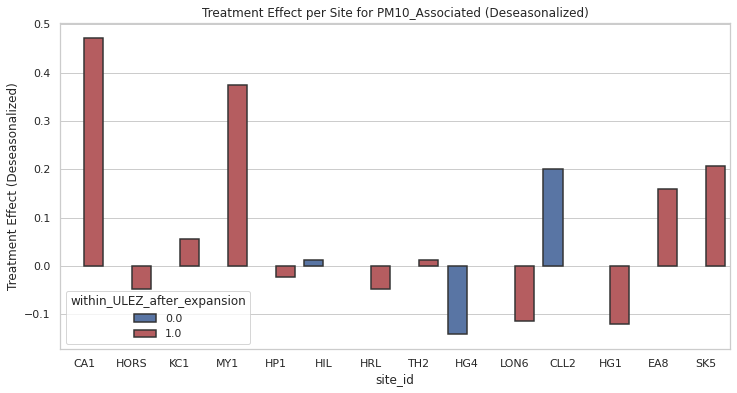

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

def perform_deseasonalized_rdd(data, outcome_var, model_type='linear_same_slope', yearly_freq=365, monthly_freq=12, plot=True):
    # Sort data by date
    data.sort_values(by='date_only', inplace=True)

    # Set the combined seasonal frequency
    combined_freq = yearly_freq * monthly_freq

    # Perform seasonal decomposition (weekly, monthly and yearly)
#     decomposition = seasonal_decompose(data[outcome_var], period=len(data.date_only.unique()), model='additive')
    decomposition = seasonal_decompose(data[outcome_var], period=7 * 365, model='additive')


    # Extract the deseasonalized component and add it to the DataFrame
    data[f'{outcome_var}_deseasonalized_monthly_yearly'] = decomposition.observed - decomposition.seasonal

    # Calculate the treatment effect for each site using the deseasonalized data (both yearly and monthly)
    site_ids = data['site_id'].unique()
    treatment_effects_deseasonalized_monthly_yearly = []
    for site_id in site_ids:
        site_data = data[data['site_id'] == site_id]
        if site_id == 'TH2':
            fitted_model, (rdd_value, rdd_percentage) = plot_rdd(site_data, outcome_var=f'{outcome_var}_deseasonalized_monthly_yearly', model_type=model_type)
        else:
            fitted_model, (rdd_value, rdd_percentage) = plot_rdd(site_data, outcome_var=f'{outcome_var}_deseasonalized_monthly_yearly', model_type=model_type, plot = False)

        treatment_effects_deseasonalized_monthly_yearly.append((site_id, rdd_value, rdd_percentage))

    # Create a DataFrame to store the treatment effects
    treatment_effects_deseasonalized_monthly_yearly_df = pd.DataFrame(treatment_effects_deseasonalized_monthly_yearly, columns=['site_id', 'treatment_effect', 'treatment_effect_percentage'])
    treatment_effects_deseasonalized_monthly_yearly_df['within_ULEZ_before_expansion'] = data.groupby('site_id')['within_ULEZ_before_expansion'].first().values
    treatment_effects_deseasonalized_monthly_yearly_df['within_ULEZ_after_expansion'] = data.groupby('site_id')['within_ULEZ_after_expansion'].first().values

    if plot:
        # Visualize the treatment effects, segregate by binary variables using line styles
        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x="site_id", y="treatment_effect", hue="within_ULEZ_after_expansion", data=treatment_effects_deseasonalized_monthly_yearly_df, palette=["b", "r"], linewidth=1.5, edgecolor=".2", capsize=0.2)
        ax.set_ylabel("Treatment Effect (Deseasonalized)")
        ax.set_title(f"Treatment Effect per Site for {outcome_var} (Deseasonalized)")
        # Set line styles
#         for i, bar in enumerate(ax.containers):
#             for line in bar:
#                 line.set_linestyle('--' if i == 0 else ':')
#         plt.show()


    return treatment_effects_deseasonalized_monthly_yearly_df
treatment_effects = perform_deseasonalized_rdd(combined_data, 'PM10_Associated', model_type='linear_same_slope', yearly_freq=365, monthly_freq=12, plot=True)

Wrong plot. Instead 1 should plot: not within -> within. 0 should be: not within -> not within (baseline). If helpful, 2: within -> within as another baseline

The sites outside of the boundary after 2021 expansion show an averagely small decrease in air pollutants like PM10. As the indicator has been standardised, the interpretability of decrease value like "-0.05" is not very significant. But we can tell from treatment effect in percentages that the improvement scale are within 10%.

## Spatial analysis
An additional spatial analysis based on the initial conclusion achieved above

In [53]:
to_merge = metadata[["site_id","latitude", "longitude"]].reset_index()
to_merge.drop(columns = ["rownames"], inplace = True)
treatment_effects = pd.merge(left = treatment_effects, right = to_merge, left_on = 'site_id', right_on = 'site_id')
# imputed_data

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda

def morans_i_and_visualize(df):
    # Create a GeoDataFrame
    geometry = gpd.points_from_xy(df.longitude, df.latitude)
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    # Calculate spatial weights matrix
    w = weights.distance.KNN.from_dataframe(gdf, k=5)
    w.transform = 'r'

    # Calculate Moran's I
    mi = esda.Moran(gdf['treatment_effect'], w)
    print(f"Moran's I: {mi.I}, p-value: {mi.p_sim}")

    # Visualize the spatial distribution of treatment effects
#     fig, ax = plt.subplots(figsize=(10, 10))
#     gdf.plot(column='treatment_effect', cmap='coolwarm', legend=True, ax=ax)
#     plt.title("Spatial Distribution of Treatment Effects")
#     plt.show()

# Create the DataFrame from the provided data
data = {'site_id': ['CA1', 'EA8', 'HG1', 'CLL2', 'LON6', 'HG4', 'SK5', 'HRL', 'HIL', 'HP1', 'TH2', 'MY1', 'KC1', 'HORS'],
        'treatment_effect': [0.450142, 0.166757, -0.113487, 0.193759, -0.023849, -0.044490, 0.166469, -0.023034, -0.053139, -0.051772, -0.041253, 0.352601, 0.091451, -0.076108],
        'treatment_effect_percentage': [44.192014, 7.213457, 9.121754, 15.854583, 3.089671, 3.491593, 7.975364, 3.323915, 8.153214, 7.871576, 3.219295, 31.717943, -12.972838, 6.006565],
        'latitude': [51.544210, 51.518950, 51.599300, 51.522290, 51.452580, 51.584128, 51.480499, 51.488790, 51.496330, 51.449674, 51.522530, 51.522530, 51.521050, 51.494670],
        'longitude': [-0.175269, -0.265617, -0.068218, -0.125889, 0.070766, -0.125254, -0.059550, -0.441614, -0.460861, -0.037418, -0.042155, -0.154611, -0.213492, -0.131931]}
df = pd.DataFrame(data)

# Perform Moran's I and visualize
morans_i_and_visualize(df)


Moran's I: -0.00917889620740952, p-value: 0.243


/opt/conda/lib/python3.10/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


The Moran's I value of -0.009 suggests little to no spatial autocorrelation in treatment effects across sites. The p-value of 0.233 indicates this observation is not statistically significant, meaning we cannot conclude that the treatment effects are spatially correlated.

# 7 Results and Discussion

* Question 1: Has the expansion of ULEZ(Ultra Low Emission Zone) in October 2021 improved air quality in London?
* Question 2: How to quantify the improvement?  
To solve these two questions, this notebook has tackled the following subquestions which are keystones of the analysis process:
 * How to categorise air pollutants into one or more synthesised indicator(s) of air quality?
 * How to confirm there is causal relationship between the expansion and the improvement?
 * What spatial patterns have been shown in the air quality imrpovements?
 
Resarch questions have been solved, as the conclusion has been achieved that the expansion of ULEZ in 25th October, 2021 did improve air quaity by a decrease of 3% to 9% in regards of PM10-associated pollutants in Greater London.

Other pollutants might need more delving into and an average performance is to be calculated. The transient time and time scope selection needs further discussion to tailor to the expansion question, which might require iterative process of section 4 to section 6.

The sub-questions have also been answered, as air pollutants have been grouped and replaced by respective principle components based on collinearity between features:
1. NOx(NO, NO2, NOXasNO2)
2. PM10&Associated(PM10, NV10, V10) 
3. PM2.5_Associated('NV2.5', 'V2.5', 'AT2.5', 'AP2.5'), 
4. SO2('SO2', 'AP10', 'CO')
5. Uncategorised: PM2.5, O3

The causal relationship was answered as a part in RDD.

The air quality improvements are observable but not siginificant. Those sites outside of expanded area generally show a clear decrease in pollutants, which might be the result of spatial spillover. 

# Bibliography

Beevers, S. D., Kitwiroon, N., Williams, M. L., Kelly, F. J., Ross Anderson, H., & Carslaw, D. C. (2013). Air pollution dispersion models for human exposure predictions in London. Journal of Exposure Science & Environmental Epidemiology, 23(6), 647–653. https://doi.org/10.1038/jes.2013.6

Cattaneo, M. D., Idrobo, N., & Titiunik, R. (2019). A practical introduction to regression discontinuity designs: An introduction. 

Ding, H., Sze, N. N., Guo, Y., & Lu, Y. (2022). Effect of the ultra-low emission zone on the usage of public bike sharing in London. Transportation Letters, 0(0), 1-9. https://doi.org/10.1080/19427867.2022.2082005

Grange, S. K., & Carslaw, D. C. (2019). Using meteorological normalisation to detect interventions in air quality time series. Science of The Total Environment, 653, 578–588. https://doi.org/10.1016/j.scitotenv.2018.10.344

Hajmohammadi, H., & Heydecker, B. (2022). Evaluation of air quality effects of the London ultra-low emission zone by state-space modelling. Atmospheric Pollution Research, 13(8), 101514. https://doi.org/10.1016/j.apr.2022.101514

Imbens, G. W., & Lemieux, T. (2008). Regression discontinuity designs: A guide to practice. Journal of Econometrics, 142(2), 615-635. https://doi.org/10.1016/j.jeconom.2007.05.001

Ma, L., Graham, D. J., & Stettler, M. E. J. (2021). Air quality impacts of new public transport provision: A causal analysis of the Jubilee Line Extension in London. Atmospheric Environment, 245, 118025. https://doi.org/10.1016/j.atmosenv.2020.118025

Ma, L., Graham, D. J., & Stettler, M. E. J. (2021). Has the ultra low emission zone in London improved air quality? Environmental Research Letters, 16(12), 124001. https://doi.org/10.1088/1748-9326/ac30c1

Tonne, C., Milà, C., Fecht, D., Alvarez, M., Gulliver, J., Smith, J., Beevers, S., Ross Anderson, H., & Kelly, F. (2018). Socioeconomic and ethnic inequalities in exposure to air and noise pollution in London. Environment International, 115, 170–179. https://doi.org/10.1016/j.envint.2018.03.023

Wing, C., Simon, K., & Bello-Gomez, R. A. (2018). Designing Difference in Difference Studies: Best Practices for Public Health Policy Research. Annual Review of Public Health, 39(1), 453-469. https://doi.org/10.1146/annurev-publhealth-040617-013507